# **Algorithmic Trading: German Electricity Market**

In [67]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
from pykalman import KalmanFilter
from scipy.stats import zscore, boxcox, yeojohnson
from scipy.stats.mstats import winsorize
from statsmodels.tsa.seasonal import STL, MSTL
import holidays

random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = pd.read_csv("train.csv", index_col=["date"], parse_dates=True)
df.index.name = "Date"
df

,wind,solar,load,spread
Date,,,,
2020-01-01 00:00:00,6084.0,0.0,43915.0,38.40
2020-01-01 00:15:00,5739.0,0.0,43770.0,-105.93
2020-01-01 00:30:00,5774.0,0.0,43267.0,-1.48
2020-01-01 00:45:00,5804.0,0.0,42934.0,3.97
2020-01-01 01:00:00,5791.0,0.0,42718.0,100.09
...,...,...,...,...
2023-12-31 22:45:00,29922.0,2.0,41550.0,102.06
2023-12-31 23:00:00,29546.0,3.0,40733.0,35.24
2023-12-31 23:15:00,29204.0,3.0,39805.0,78.57


## **Exploratory Data Analysis (EDA)**

In [5]:
df.isnull().sum()

wind      0
solar     0
load      0
spread    0
dtype: int64

### **Time Series Evolutions**

In [6]:
PLOT_CONFIGS = {
    "wind": {
        "title": "German day-ahead wind power forecast (MW)", 
        "label": "Wind Forecast", 
        "color": "blue", 
        "ylabel": "Megawatt (MW)"
    },
    "solar": {
        "title": "German day-ahead solar power forecast (MW)", 
        "label": "Solar Forecast", 
        "color": "orange", 
        "ylabel": "Megawatt (MW)"
    },
    "load": {
        "title": "German day-ahead load forecast (MW)", 
        "label": "Load Forecast", 
        "color": "green", 
        "ylabel": "Megawatt (MW)"
    },
    "spread": {
        "title": "Difference between Imbalances and Day-Ahead price (€)", 
        "label": "Price Spread", 
        "color": "red",  
        "ylabel": "Euro (€)"
    }
}


def plot_all(df):
    wind_data = df["wind"].values
    kf = KalmanFilter(
        initial_state_mean=wind_data[0],
        transition_matrices=[1],  # Random walk
        observation_matrices=[1],
        transition_covariance=1e-3,  # Small process noise
        observation_covariance=1e2   # Large observation noise
    )
    state_means_smooth, _ = kf.smooth(wind_data)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.tight_layout(h_pad=5, w_pad=4)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(PLOT_CONFIGS.items()):
        axes[idx].plot(df.index, df[col], label=config["label"], color=config["color"])
        if col == "wind":
            axes[idx].plot(df.index, state_means_smooth, label="Kalman Smoother", color="red", linewidth=2)
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Date")
        axes[idx].set_title(config["title"])
        axes[idx].legend()
        axes[idx].grid(True)
    plt.show()


def plot_day(df, date=None):
    """
    Plots a specific day's data for all columns in a 2x2 grid using plot_configs.
    
    Args:
        df (pd.DataFrame): The data containing time series for multiple features.
        date (str): The date to plot (format: "YYYY-MM-DD").
        plot_configs (dict): Dictionary containing plot configurations for each column.
    """

    if date is None:
        unique_days = df.index.date
        date = random.choice(unique_days)
        day_data = df[df.index.date == date]
    else:
        day_data = df.loc[date]
    
    if day_data.empty:
        print(f"No data available for the selected date: {date}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"German Energy Forecasts for {date}", fontsize=16, fontweight='bold', y=0.95)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(PLOT_CONFIGS.items()):
        axes[idx].plot(day_data.index, day_data[col], label=config["label"], color=config["color"])
        if col == "spread":
            axes[idx].axhline(day_data["spread"].mean(), color="blue", linestyle='--', label="Average spread")
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Time")
        axes[idx].set_title(config["title"])
        axes[idx].legend()
        axes[idx].grid(True)

        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[idx].xaxis.set_major_locator(mdates.HourLocator(interval=4))
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=0)

    plt.show()


def plot_week(df, start_date=None):
    """
    Plots a full week's data (Monday to Sunday) for all columns in a 2x2 grid using plot_configs.

    Args:
        df (pd.DataFrame): The data containing time series for multiple features.
        start_date (str): A date within the desired week (format: "YYYY-MM-DD"). If None, a random Monday is chosen.
        plot_configs (dict): Dictionary containing plot configurations for each column.
    """
    if start_date is None:
        unique_days = pd.to_datetime(df.index.date)
        mondays = unique_days[unique_days.weekday == 0]
        if len(mondays) == 0:
            print("No Mondays found in the dataset.")
            return
        start_date = random.choice(mondays)
    else:
        start_date = pd.to_datetime(start_date)
        if start_date.weekday != 0:
            start_date = start_date - pd.Timedelta(days=start_date.weekday())  # Adjust to previous Monday

    # Calculate the end of the week (Sunday)
    end_date = start_date + pd.Timedelta(days=7)
    week_data = df.loc[start_date:end_date]

    if week_data.empty:
        print(f"No data available for the week starting on: {start_date.date()}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Week: {start_date.date()} to {end_date.date()}", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=6, w_pad=4)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(PLOT_CONFIGS.items()):
        axes[idx].plot(week_data.index, week_data[col], label=config["label"], color=config["color"])
        if col == "spread":
            axes[idx].axhline(week_data["spread"].mean(), color="blue", linestyle='--', label="Average spread")
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Day")
        axes[idx].set_title(config["title"], fontsize=14, fontweight="bold")
        axes[idx].legend()
        axes[idx].grid(True)

        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
        axes[idx].xaxis.set_major_locator(mdates.DayLocator())
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

    plt.show()

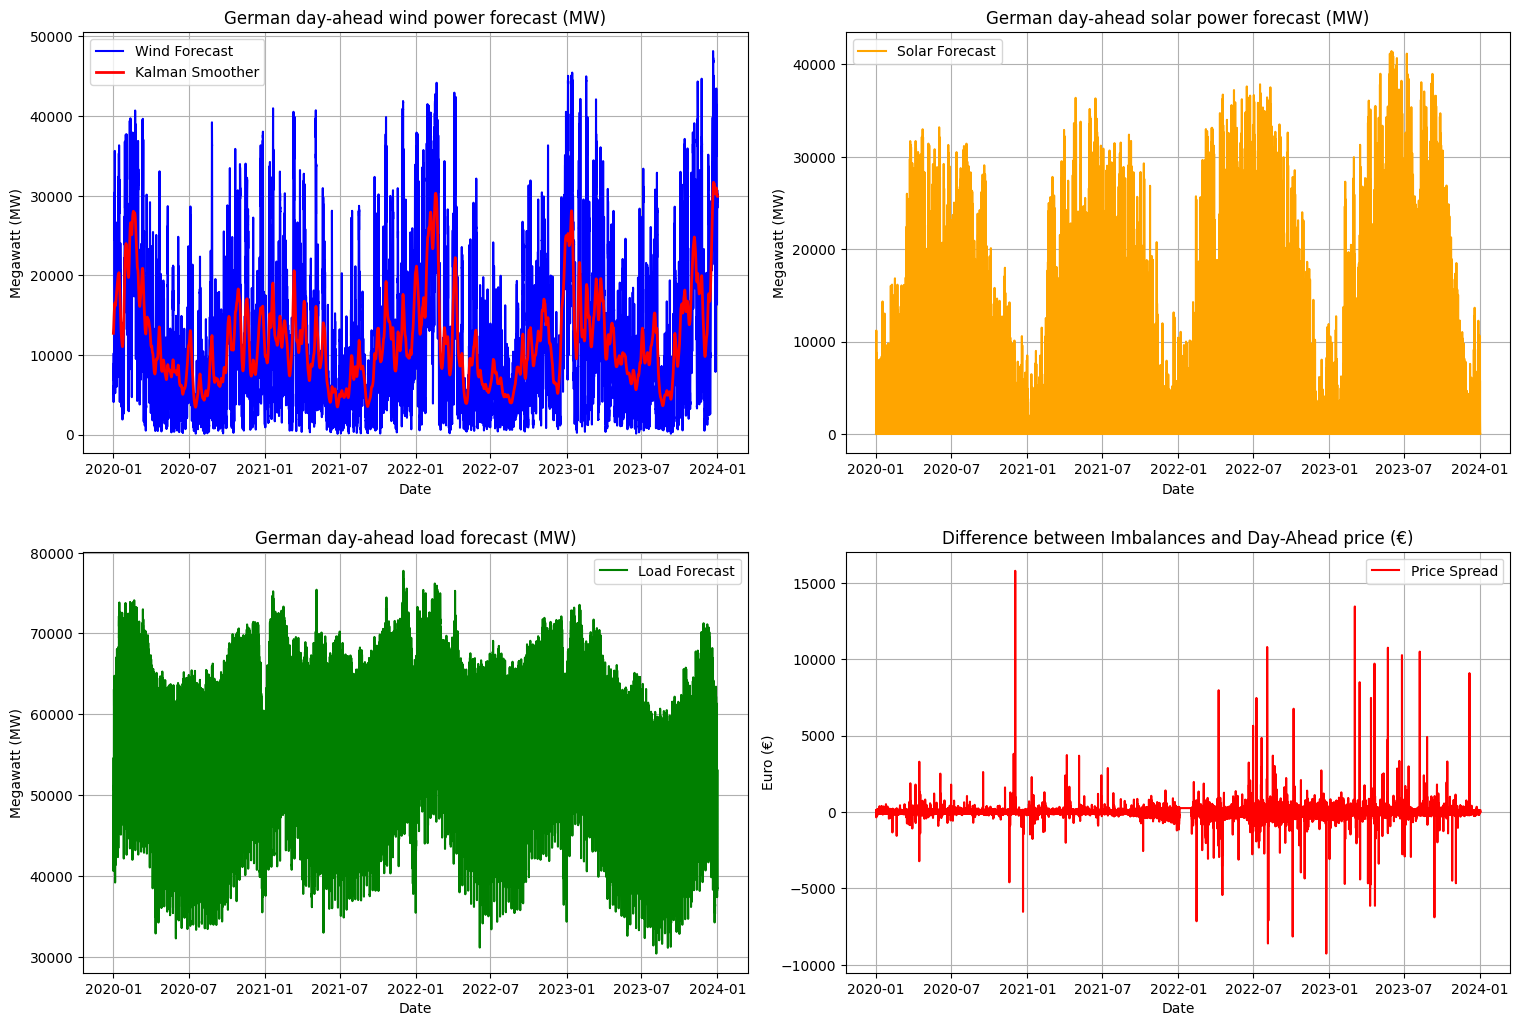

In [7]:
plot_all(df)

- **Wind Power Forecasts (Top Left):** Wind power forecasts demonstrate some yearly seasonal patterns, with reduced wind activity typically observed during the summer months and increased wind levels during winter. 

- **Solar Power Forecasts (Top Right):** Solar power forecasts exhibit a well-defined yearly seasonality, with the lowest levels occurring consistently between December and February. This pattern aligns with reduced daylight hours during winter, providing a predictable trend that is easier to model compared to wind power.

- **Load Forecasts (Bottom Left):** Load forecasts indicate moderate yearly seasonality, with higher demand generally observed from autumn to winter, driven by increased heating needs. Notably, there is a significant dip in late December, likely attributable to reduced economic activity during the Christmas holidays.

- **Spread Between Imbalance and Day-Ahead Prices (Bottom Right):** The spreadappears to be close to 0 most of the 0 however it reveals sudden spikes with ones more pronounced than others particularly after 2022 compared to earlier periods. 

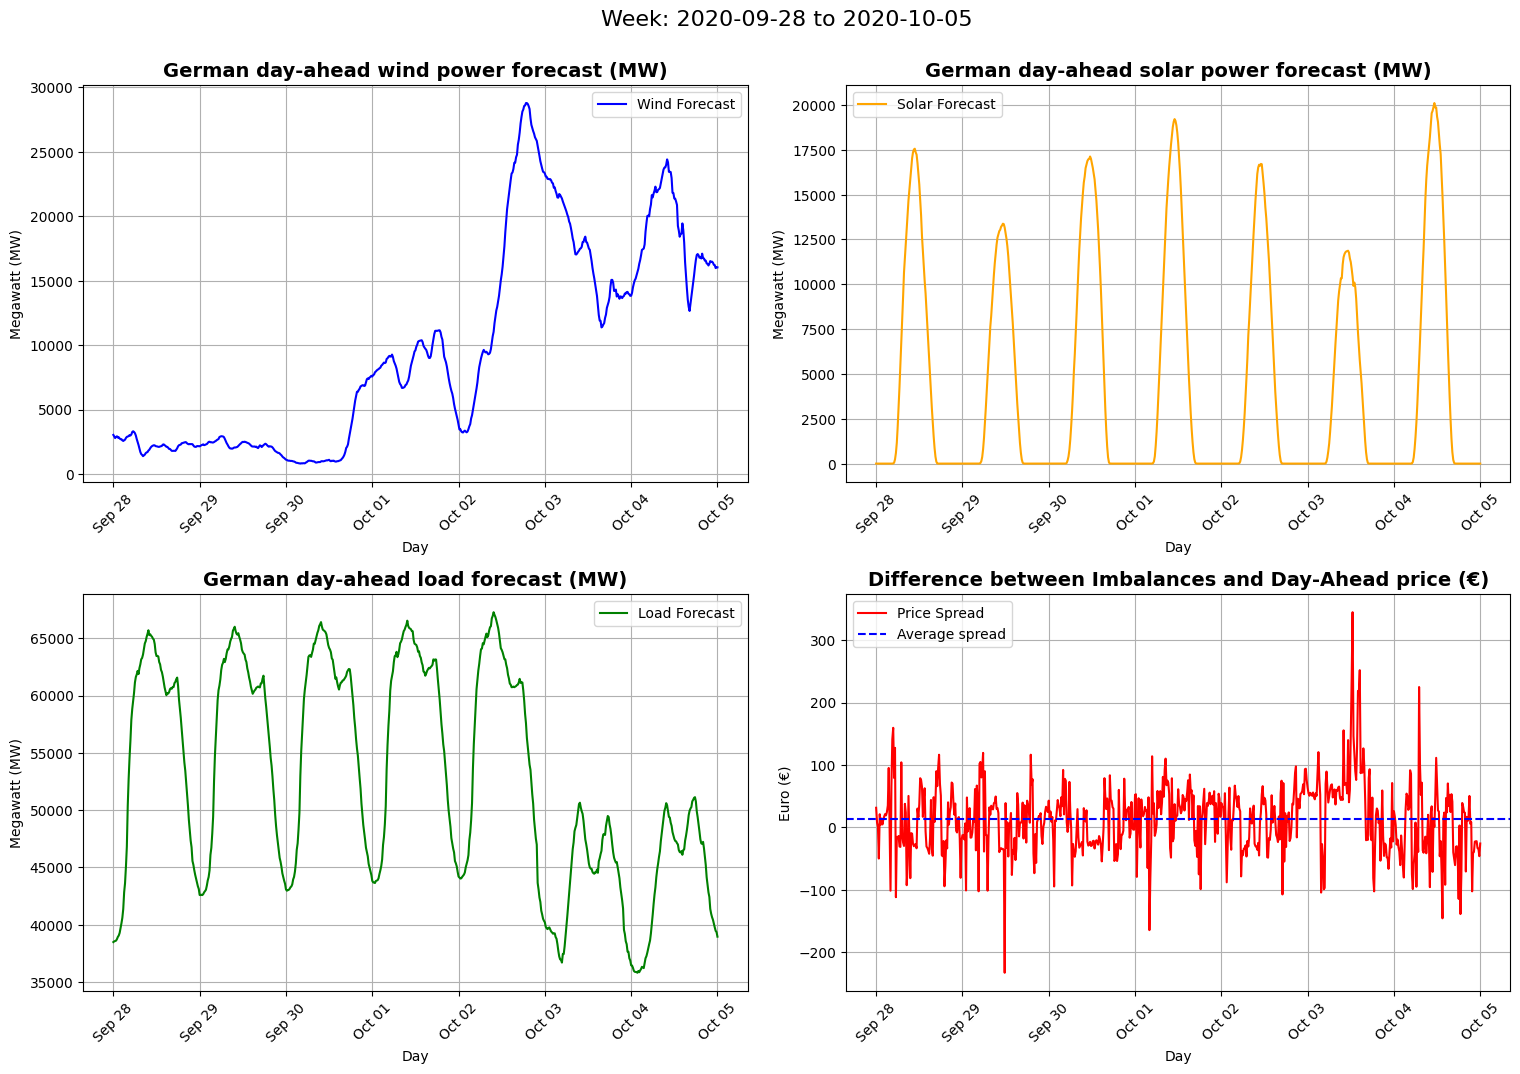

In [8]:
random.seed(42)
plot_week(df)

- Throughout the day, wind power forecasts exhibit smoother patterns, while solar forecasts show a clear peak around noon, following a near-normal distribution. In contrast, load forecasts and the spread are significantly more volatile. The spread appears to mean-revert around zero, which is expected given its nature as a derived metric balancing supply and demand fluctuations.

- There are notable spikes in the price spread on October 3rd and 4th, which are somewhat challenging to interpret. During this period, wind power forecasts remain relatively high compared to earlier days in the week (indicating high supply), while the load forecast reaches its lowest levels of the week (indicating low demand). At the same time, solar power forecasts are at minimal levels, contributing to reduced supply.

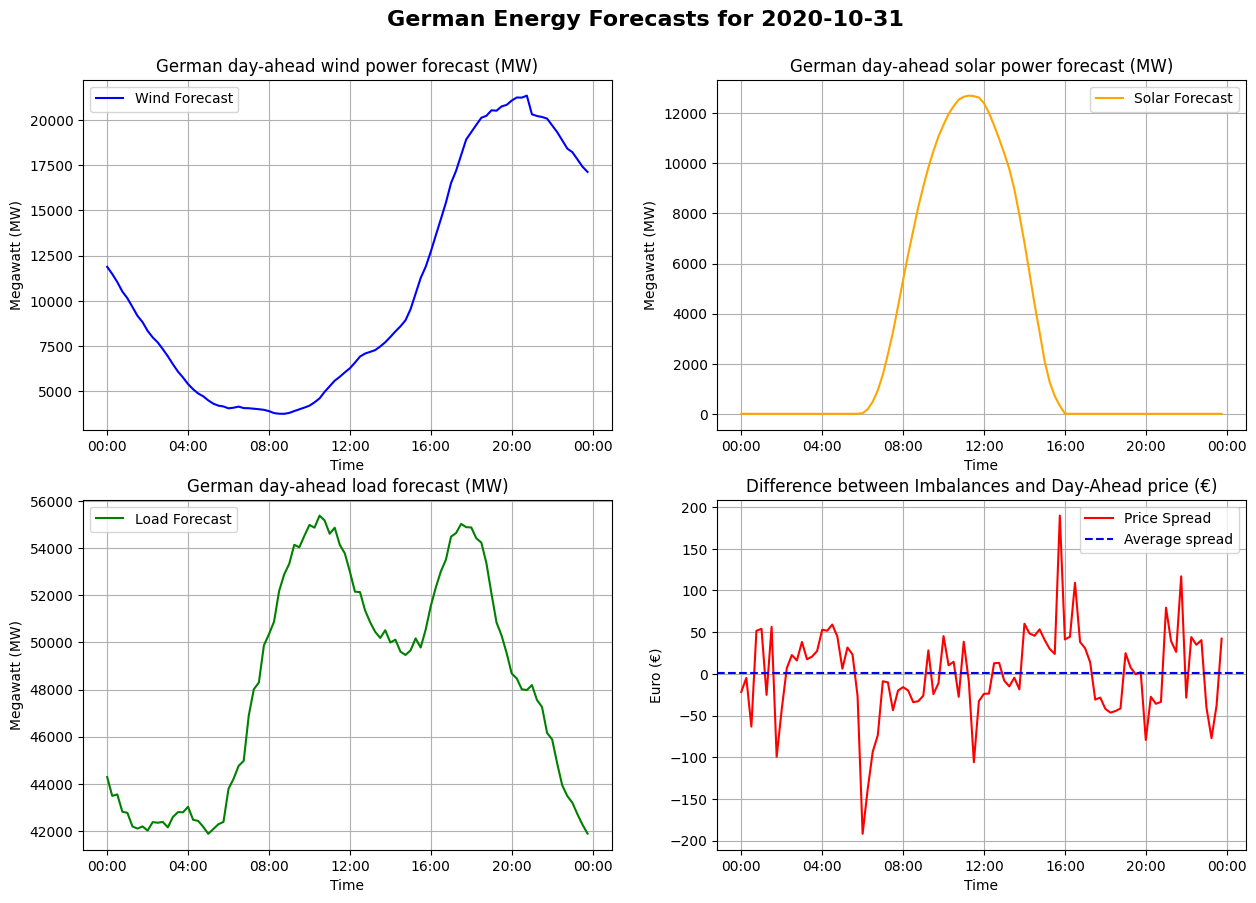

In [9]:
random.seed(42)
plot_day(df)

### **Seasonality Analysis**

With 15-min data, one day is 96 observations (96x15 = 1440 min = 24 hours) and one week is 672 (96x7)

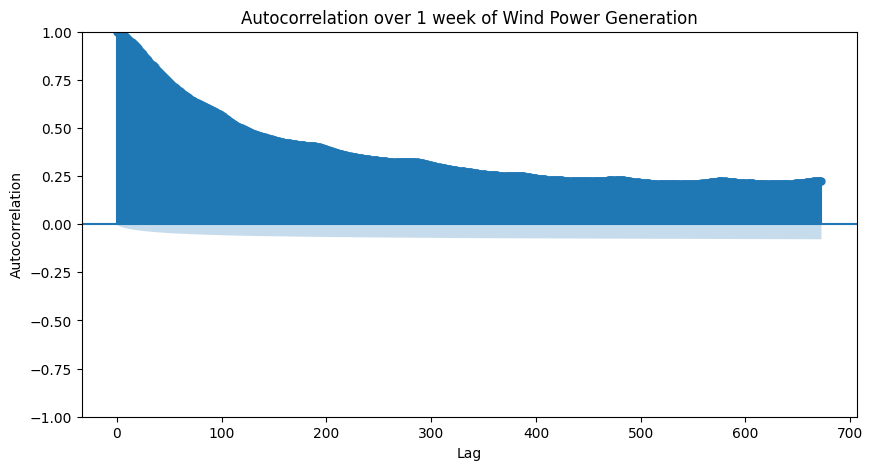

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df["wind"], lags=672, ax=ax, title="Autocorrelation over 1 week of Wind Power Generation")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.show()

For wind generation, there is a high level autocorrelation intraday, after one day it is approx 65% and after one week it is approx 25%.

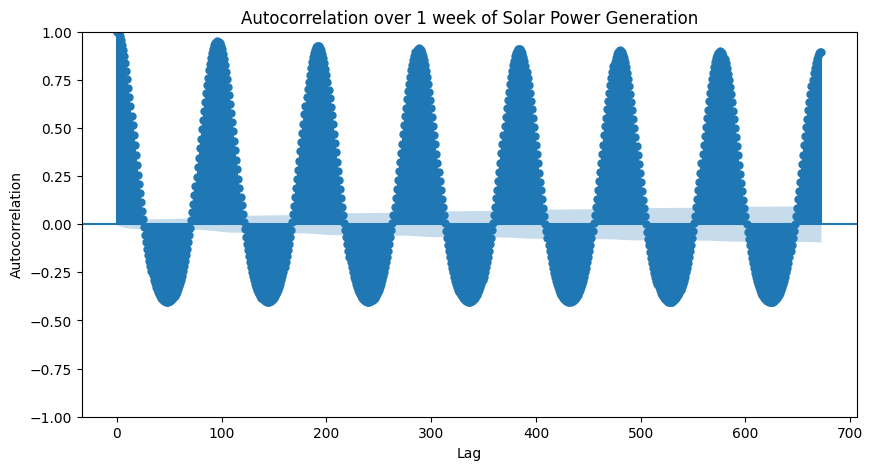

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df["solar"], lags=672, ax=ax, title="Autocorrelation over 1 week of Solar Power Generation")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.show()

Compared to wind power, solar displays a strong daily seasonailiy where at every multiple of 96 lags we observe a spike in autocorrelation. This phenomena makes sense sun rises everyday over the course of the week at the same time and with approximately the same intensity.

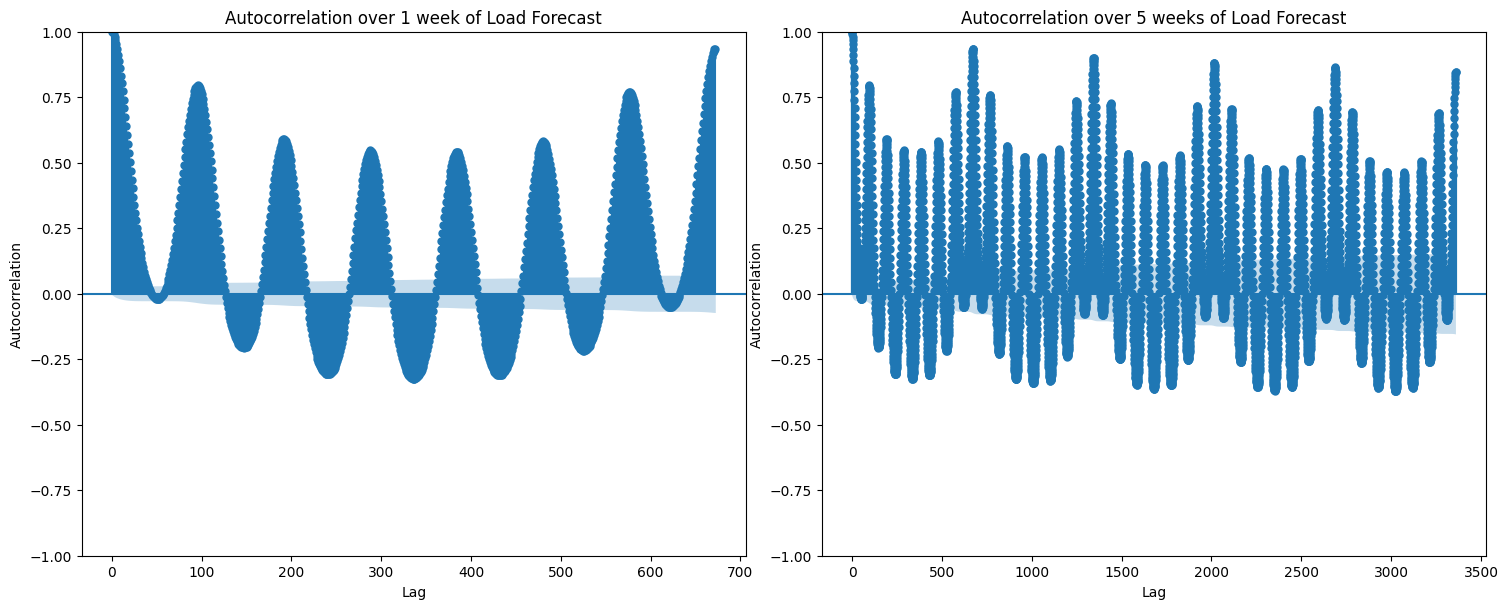

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(df["load"], lags=672, ax=axes[0], title="Autocorrelation over 1 week of Load Forecast")
plot_acf(df["load"], lags=3360, ax=axes[1], title="Autocorrelation over 5 weeks of Load Forecast")
fig.tight_layout()
axes[0].set_xlabel("Lag")
axes[1].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")
axes[1].set_ylabel("Autocorrelation")
plt.xlabel("Lag")
plt.show()

For load, there is both a daily and a weekly seasonality where multiples of 672 display very high autocorrelation levels, indicating a weekly seasonality 

### **Distribution Analysis & Outliers Detection**

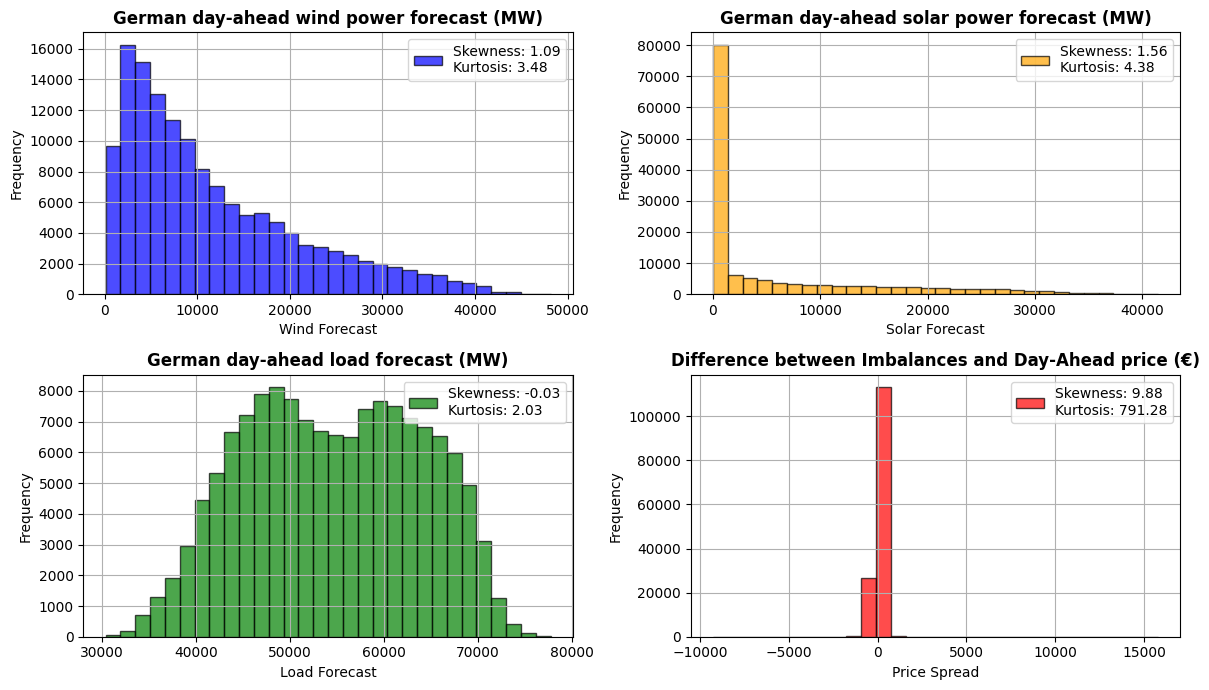

In [13]:
def plot_histograms(df, bins=30, figsize=(12, 8), title=None):
    """
    Plots histograms for up to 4 columns in a 2x2 grid with unique colors,
    displaying skewness and kurtosis as a legend for each plot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        plot_configs (dict): Plot configuration dictionary for each column.
        bins (int): Number of bins for the histograms.
        figsize (tuple): Size of the figure.
    """
    cols = df.columns
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16, fontweight="bold")
    axes = axes.flatten()  

    for idx, col in enumerate(cols):
        skewness = stats.skew(df[col].dropna())
        kurtosis = stats.kurtosis(df[col].dropna(), fisher=False)

        axes[idx].hist(df[col].dropna(), bins=bins, color=PLOT_CONFIGS[col]["color"], alpha=0.7, edgecolor="black")
        axes[idx].set_title(PLOT_CONFIGS[col]["title"], fontsize=12, fontweight="bold")
        axes[idx].set_xlabel(PLOT_CONFIGS[col]["label"])
        axes[idx].set_ylabel("Frequency")
        axes[idx].grid(True)
        axes[idx].legend([f"Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}"], loc="upper right", fontsize=10)

    for idx in range(len(cols), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


def plot_histograms(df, bins=30, figsize=(12, 8), title=None, plot_configs=None):
    """
    Plots histograms for a DataFrame's columns. Adapts to single or multiple columns
    and supports a grid layout for multiple variables.

    Args:
        df (pd.DataFrame or pd.Series): DataFrame or Series containing the data.
        bins (int): Number of bins for the histograms.
        figsize (tuple): Size of the figure.
        title (str): Overall title for the plot (optional).
        plot_configs (dict): Optional plot configuration dictionary for each column.
                             Uses global PLOT_CONFIGS if not provided.
    """
    # Fallback to global PLOT_CONFIGS if none is provided
    if plot_configs is None:
        plot_configs = PLOT_CONFIGS

    # If only a single column is provided, treat it as a Series
    if isinstance(df, pd.Series) or df.shape[1] == 1:
        column = df.columns[0] if isinstance(df, pd.DataFrame) else df.name
        skewness = stats.skew(df.dropna())
        kurtosis = stats.kurtosis(df.dropna(), fisher=False)

        plt.figure(figsize=figsize)
        plt.hist(df.dropna(), bins=bins, color=plot_configs[column]["color"], alpha=0.7, edgecolor="black")
        plt.title(plot_configs[column]["title"], fontsize=12, fontweight="bold")
        plt.xlabel(plot_configs[column]["label"])
        plt.ylabel("Frequency")
        plt.legend([f"Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}"], loc="upper right", fontsize=10)
        plt.grid(True)
        if title is not None:
            plt.title(title, fontsize=16, fontweight="bold")
        plt.tight_layout()
        plt.show()
    else:
        num_cols = df.shape[1]
        rows = int(np.ceil(np.sqrt(num_cols)))
        cols_in_row = int(np.ceil(num_cols / rows))

        fig, axes = plt.subplots(rows, cols_in_row, figsize=figsize)
        if title is not None:
            fig.suptitle(title, fontsize=16, fontweight="bold")
        axes = axes.flatten()

        for idx, col in enumerate(df.columns):
            skewness = stats.skew(df[col].dropna())
            kurtosis = stats.kurtosis(df[col].dropna(), fisher=False)

            axes[idx].hist(df[col].dropna(), bins=bins, color=plot_configs[col]["color"], alpha=0.7, edgecolor="black")
            axes[idx].set_title(plot_configs[col]["title"], fontsize=12, fontweight="bold")
            axes[idx].set_xlabel(plot_configs[col]["label"])
            axes[idx].set_ylabel("Frequency")
            axes[idx].grid(True)
            axes[idx].legend([f"Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}"], loc="upper right", fontsize=10)

        for idx in range(num_cols, len(axes)):
            axes[idx].axis("off")

        plt.tight_layout()
        plt.show()

plot_histograms(df[["wind", "solar", "load", "spread"]], figsize=(12, 7))

- **Wind Power Forecast (Top Left)**: The distribution is positively skewed, with most values concentrated at lower power levels and a long tail of occasional high wind forecasts, reflecting the variability of wind generation.

- **Solar Power Forecast (Top Right)**: A heavily right-skewed distribution, with most values near zero, indicates low generation during nighttime or cloudy periods, with peaks corresponding to sunny conditions.

- **Load Forecast (Bottom Left)**: The nearly symmetric, slightly bimodal distribution reflects varying energy consumption patterns, likely driven by differences between weekdays and weekends or daily demand cycles.

- **Spread Between Imbalance and Day-Ahead Prices (Bottom Right)**: The distribution is centered tightly around zero, suggesting close alignment between the two prices, however large outliers cause the dsitribution to have a very poor shape with a high **Skewness** and **Kurtosis**.

*Note: For load forecasts we assume that the distribution is closer to **normal** than **bimodal** because the histogram does not display two distinct peaks that are clearly separated.*

We might consider removing outliers based on the overall distribution, such as filtering wind values above 40,000 or solar values above 35,000. However, this approach overlooks a key aspect of time series data: seasonality. The distribution of data can vary significantly across seasons, months, or even years, making it crucial to account for these temporal patterns.

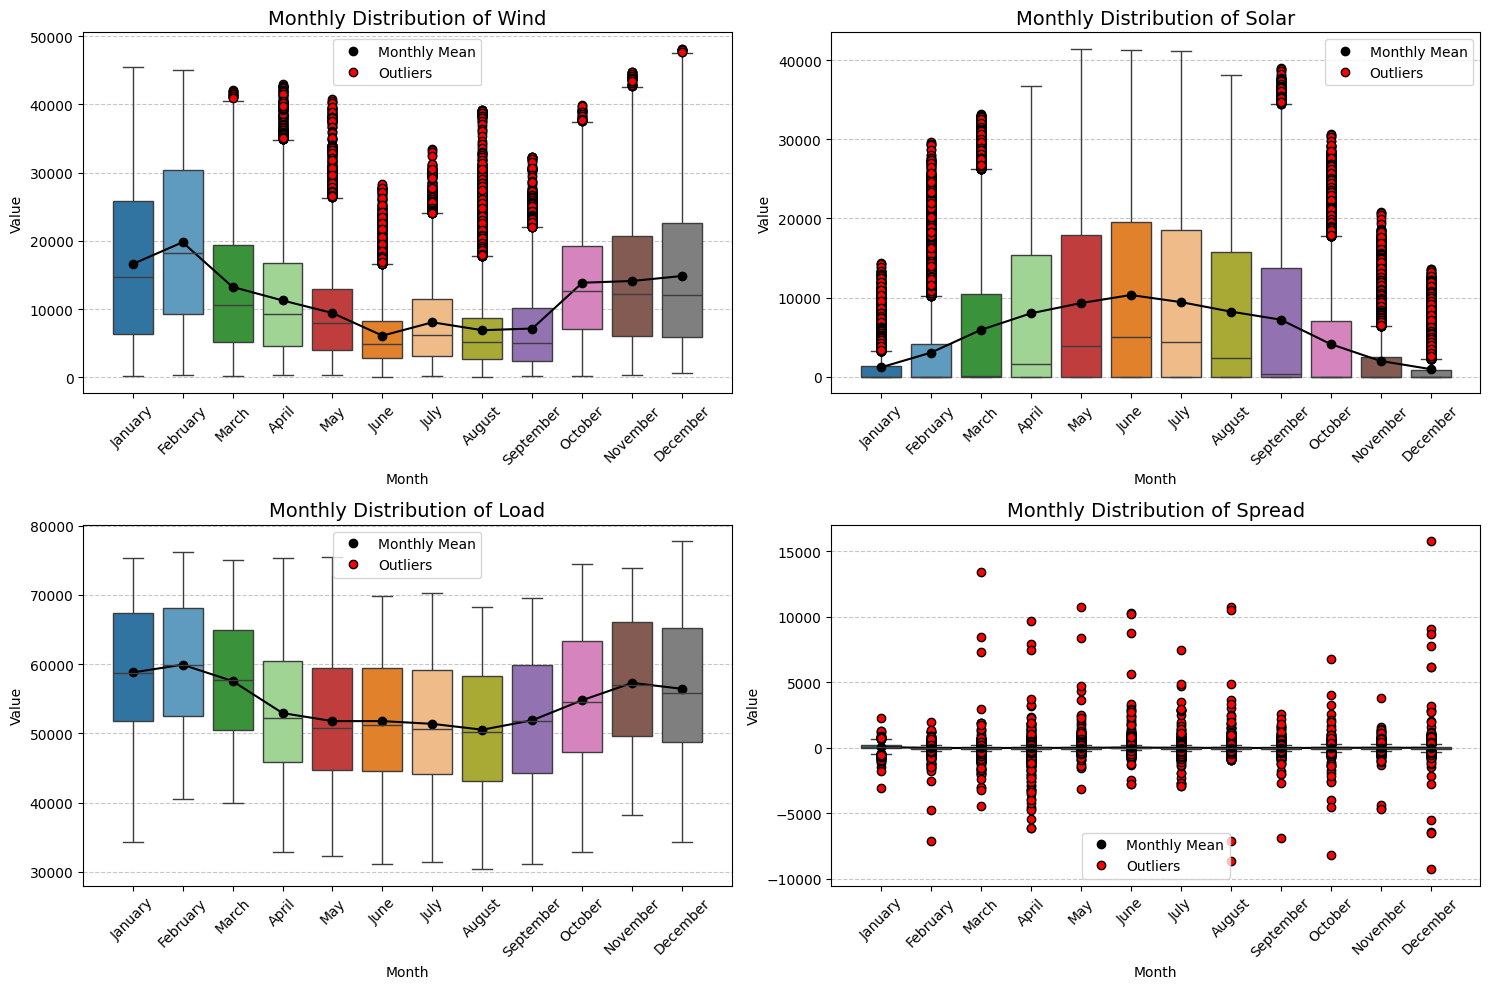

In [14]:
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 
                 'July', 'August', 'September', 'October', 'November', 'December']

def plot_monthly_boxplots(df, columns):
    """
    Plots boxplots for the monthly distribution of selected variables with rainbow colors and a legend.

    Args:
        df (pd.DataFrame): The input time-series dataframe with a DatetimeIndex.
        columns (list): List of column names to create boxplots for.
    """
    df['Month'] = df.index.month_name()

    seasonal_colors = {
        "January": "#1f77b4", "February": "#4f9dcf", "March": "#2ca02c",
        "April": "#98df8a", "May": "#d62728", "June": "#ff7f0e",
        "July": "#ffbb78", "August": "#bcbd22", "September": "#9467bd",
        "October": "#e377c2", "November": "#8c564b", "December": "#7f7f7f"
    }

    for column in columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=df, x="Month", hue="Month", y=column, order=MONTHS, legend=False, 
            palette=seasonal_colors, flierprops={'markerfacecolor': 'red', 'markeredgecolor': 'black'}
        )
        
        # Overlay monthly means
        monthly_means = df.groupby("Month")[column].mean().reindex(MONTHS)
        plt.plot(range(len(monthly_means)), monthly_means, marker='o', color='black', label="Monthly Mean")
        plt.title(f"Monthly Distribution of {column.capitalize()}", fontsize=14)
        plt.xlabel("Month")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.xticks(rotation=45)
        plt.legend(
            handles=[
                plt.Line2D([], [], color='black', marker='o', linestyle='', label='Monthly Mean'),
                plt.Line2D([], [], color='red', marker='o', markeredgecolor='black', linestyle='', label='Outliers')
            ]
        )

        plt.show()

def plot_monthly_boxplots(df, columns, rows=2, cols=2):
    """
    Plots boxplots for the monthly distribution of selected variables in a grid.

    Args:
        df (pd.DataFrame): The input time-series dataframe with a DatetimeIndex.
        columns (list): List of column names to create boxplots for.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    df['Month'] = df.index.month_name()

    seasonal_colors = {
        "January": "#1f77b4", "February": "#4f9dcf", "March": "#2ca02c",
        "April": "#98df8a", "May": "#d62728", "June": "#ff7f0e",
        "July": "#ffbb78", "August": "#bcbd22", "September": "#9467bd",
        "October": "#e377c2", "November": "#8c564b", "December": "#7f7f7f"
    }

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for idx, column in enumerate(columns):
        sns.boxplot(
            data=df, x="Month", hue="Month", y=column, order=MONTHS, ax=axes[idx], legend=False,
            palette=seasonal_colors, flierprops={'markerfacecolor': 'red', 'markeredgecolor': 'black'}
        )
        
        monthly_means = df.groupby("Month")[column].mean().reindex(MONTHS)
        axes[idx].plot(range(len(monthly_means)), monthly_means, marker='o', color='black', label="Monthly Mean")
        axes[idx].set_title(f"Monthly Distribution of {column.capitalize()}", fontsize=14)
        axes[idx].set_xlabel("Month")
        axes[idx].set_ylabel("Value")
        axes[idx].grid(axis="y", linestyle="--", alpha=0.7)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend(
            handles=[
                plt.Line2D([], [], color='black', marker='o', linestyle='', label='Monthly Mean'),
                plt.Line2D([], [], color='red', marker='o', markeredgecolor='black', linestyle='', label='Outliers')
            ]
        )

    for idx in range(len(columns), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

plot_monthly_boxplots(df, columns=["wind", "solar", "load", "spread"])

- **Wind Forecasts:** Wind power displays a clear seasonal pattern, with lower values during summer. The variability and chaotic nature of wind are reflected in the numerous outliers observed, especially in summer months. While the mean (black dot) is generally close to the median (horizontal line), the presence of these outliers suggests some degree of skewness in the distribution.

- **Solar Forecasts:** Solar forecasts show no significant outliers during spring and summer, but many emerge in fall and winter. The higher mean compared to the median during colder months indicates a skewed distribution for different from 0 solar forecasts, highlighting the need for careful handling of these values.

- **Load Forecasts:** Load data is consistent across months, with no significant outliers. Seasonal trends show slightly higher demand in fall and winter, likely due to heating needs. The close alignment between the mean and median reflects a symmetric distribution, suggesting that no additional outlier handling or transformations are needed.

- **Spread:** The spread mostly remains near 0, as indicated by the narrow box plot, but extreme outliers occur frequently, representing significant deviations between imbalance and day-ahead prices.

**Conclusion:** For load forecasts, no additional data processing is necessary since the distribution is well-behaved and free from significant outliers. However, for solar and wind forecasts furtehr investigations are required to understand what tehse outliers represent. Lastly,for the spread large outliers are observed all over the months, so a good idea would be to reduce their amplitude and check wether the dsitribution looks symmetric and the kurtosis and skewness have been reduced.

 In order to have a finer look at the outliers for wind and solar, we plot the distribution of each month across all the years. Indeed, as observed in the time series from 2020 to 2024, the distribution evolves over the years, as seen with solar power generation forecasts for instance.

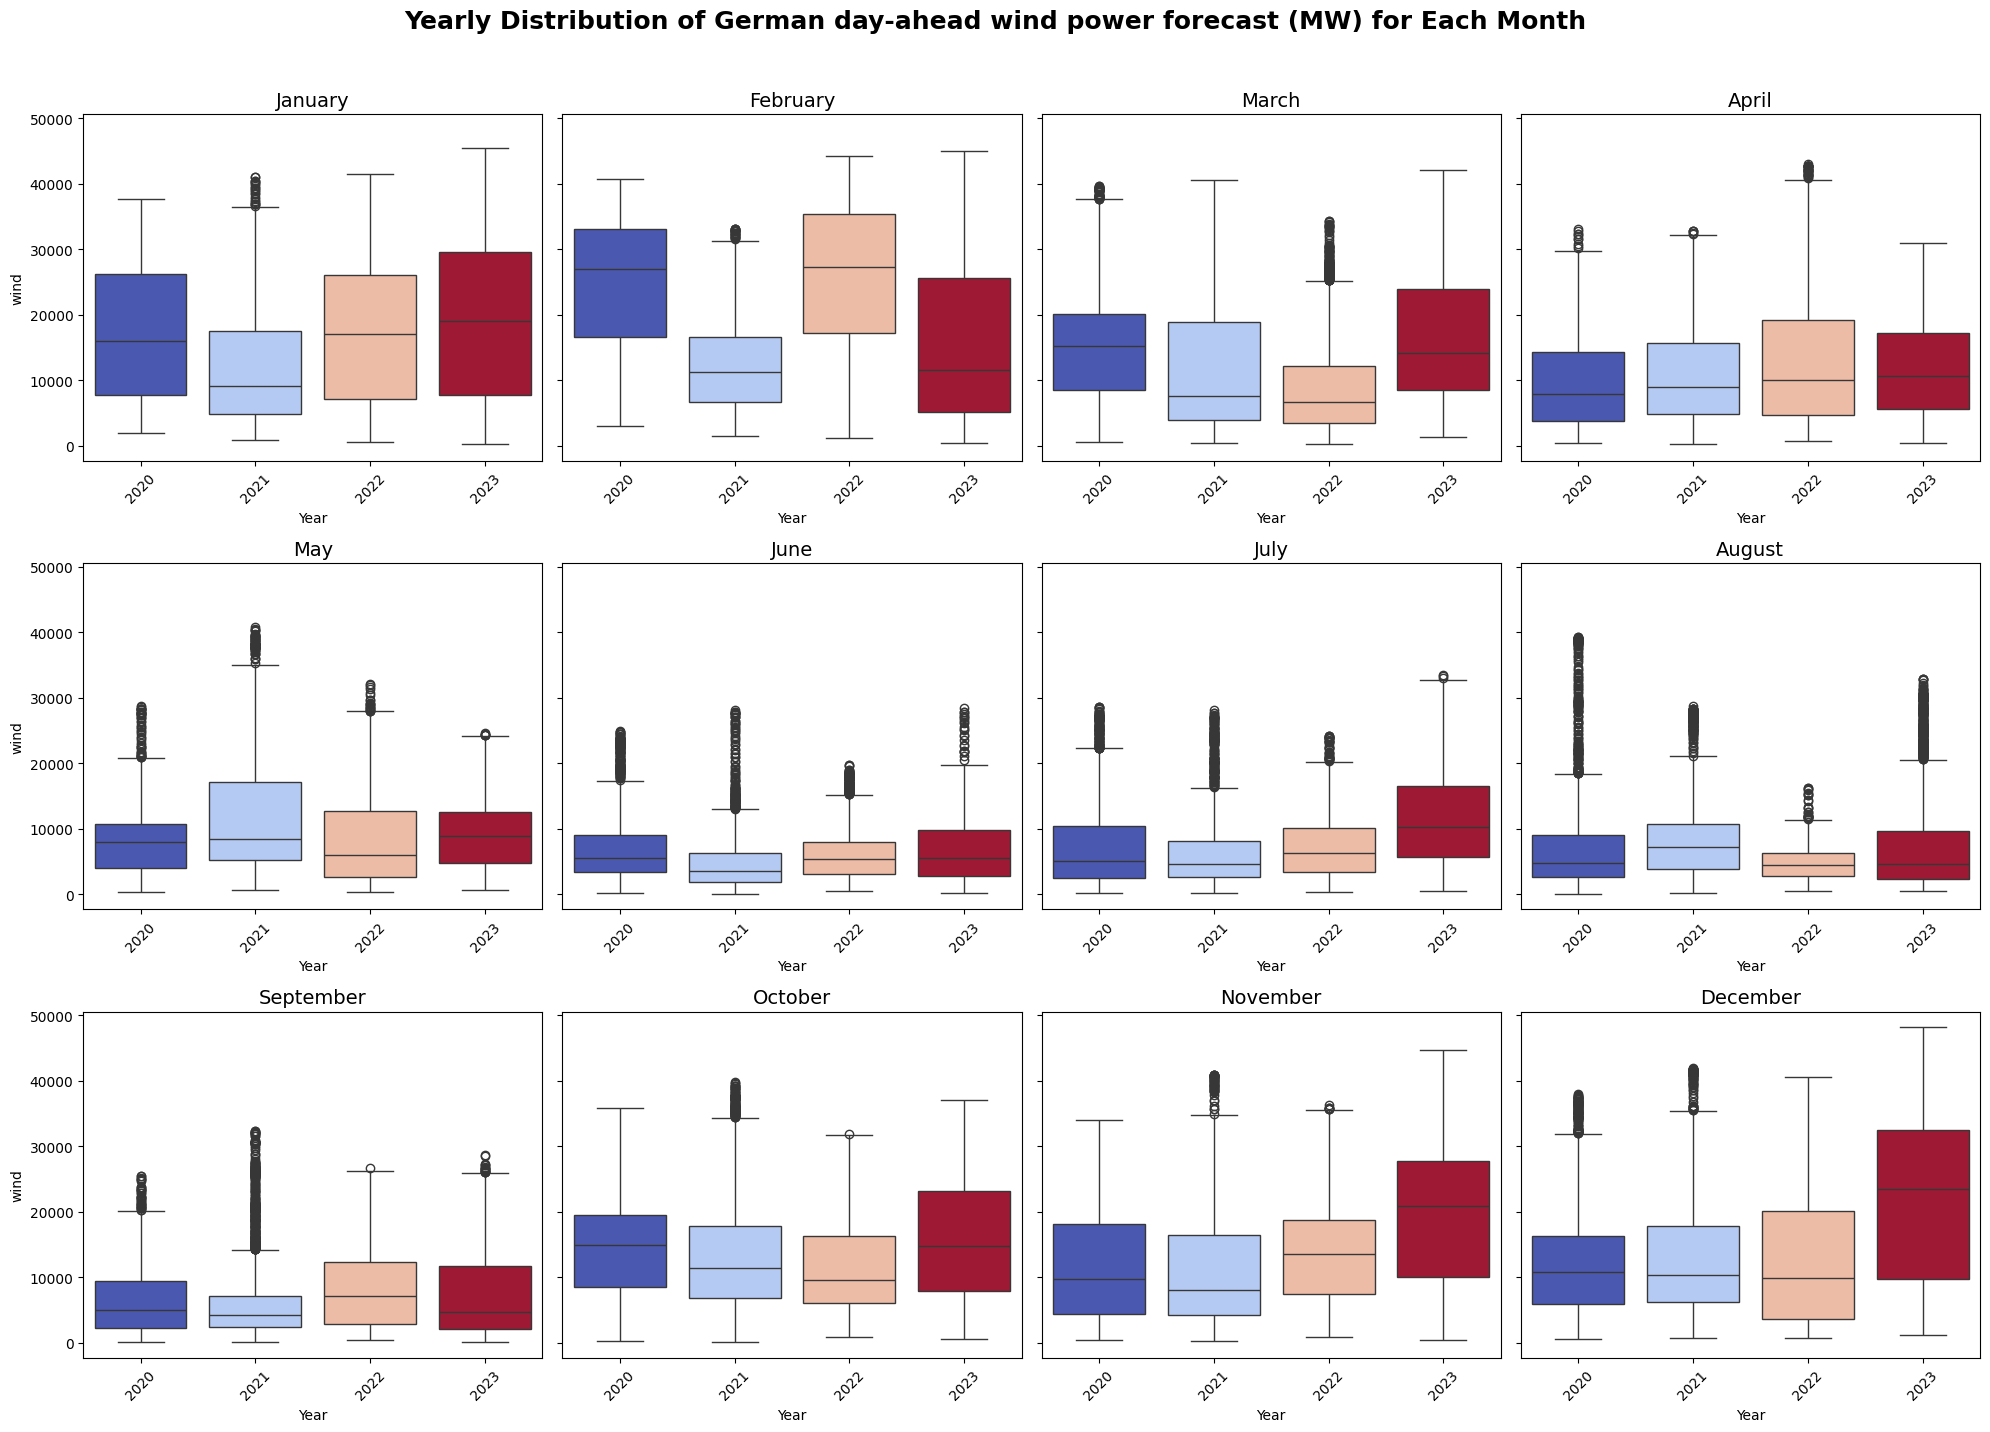

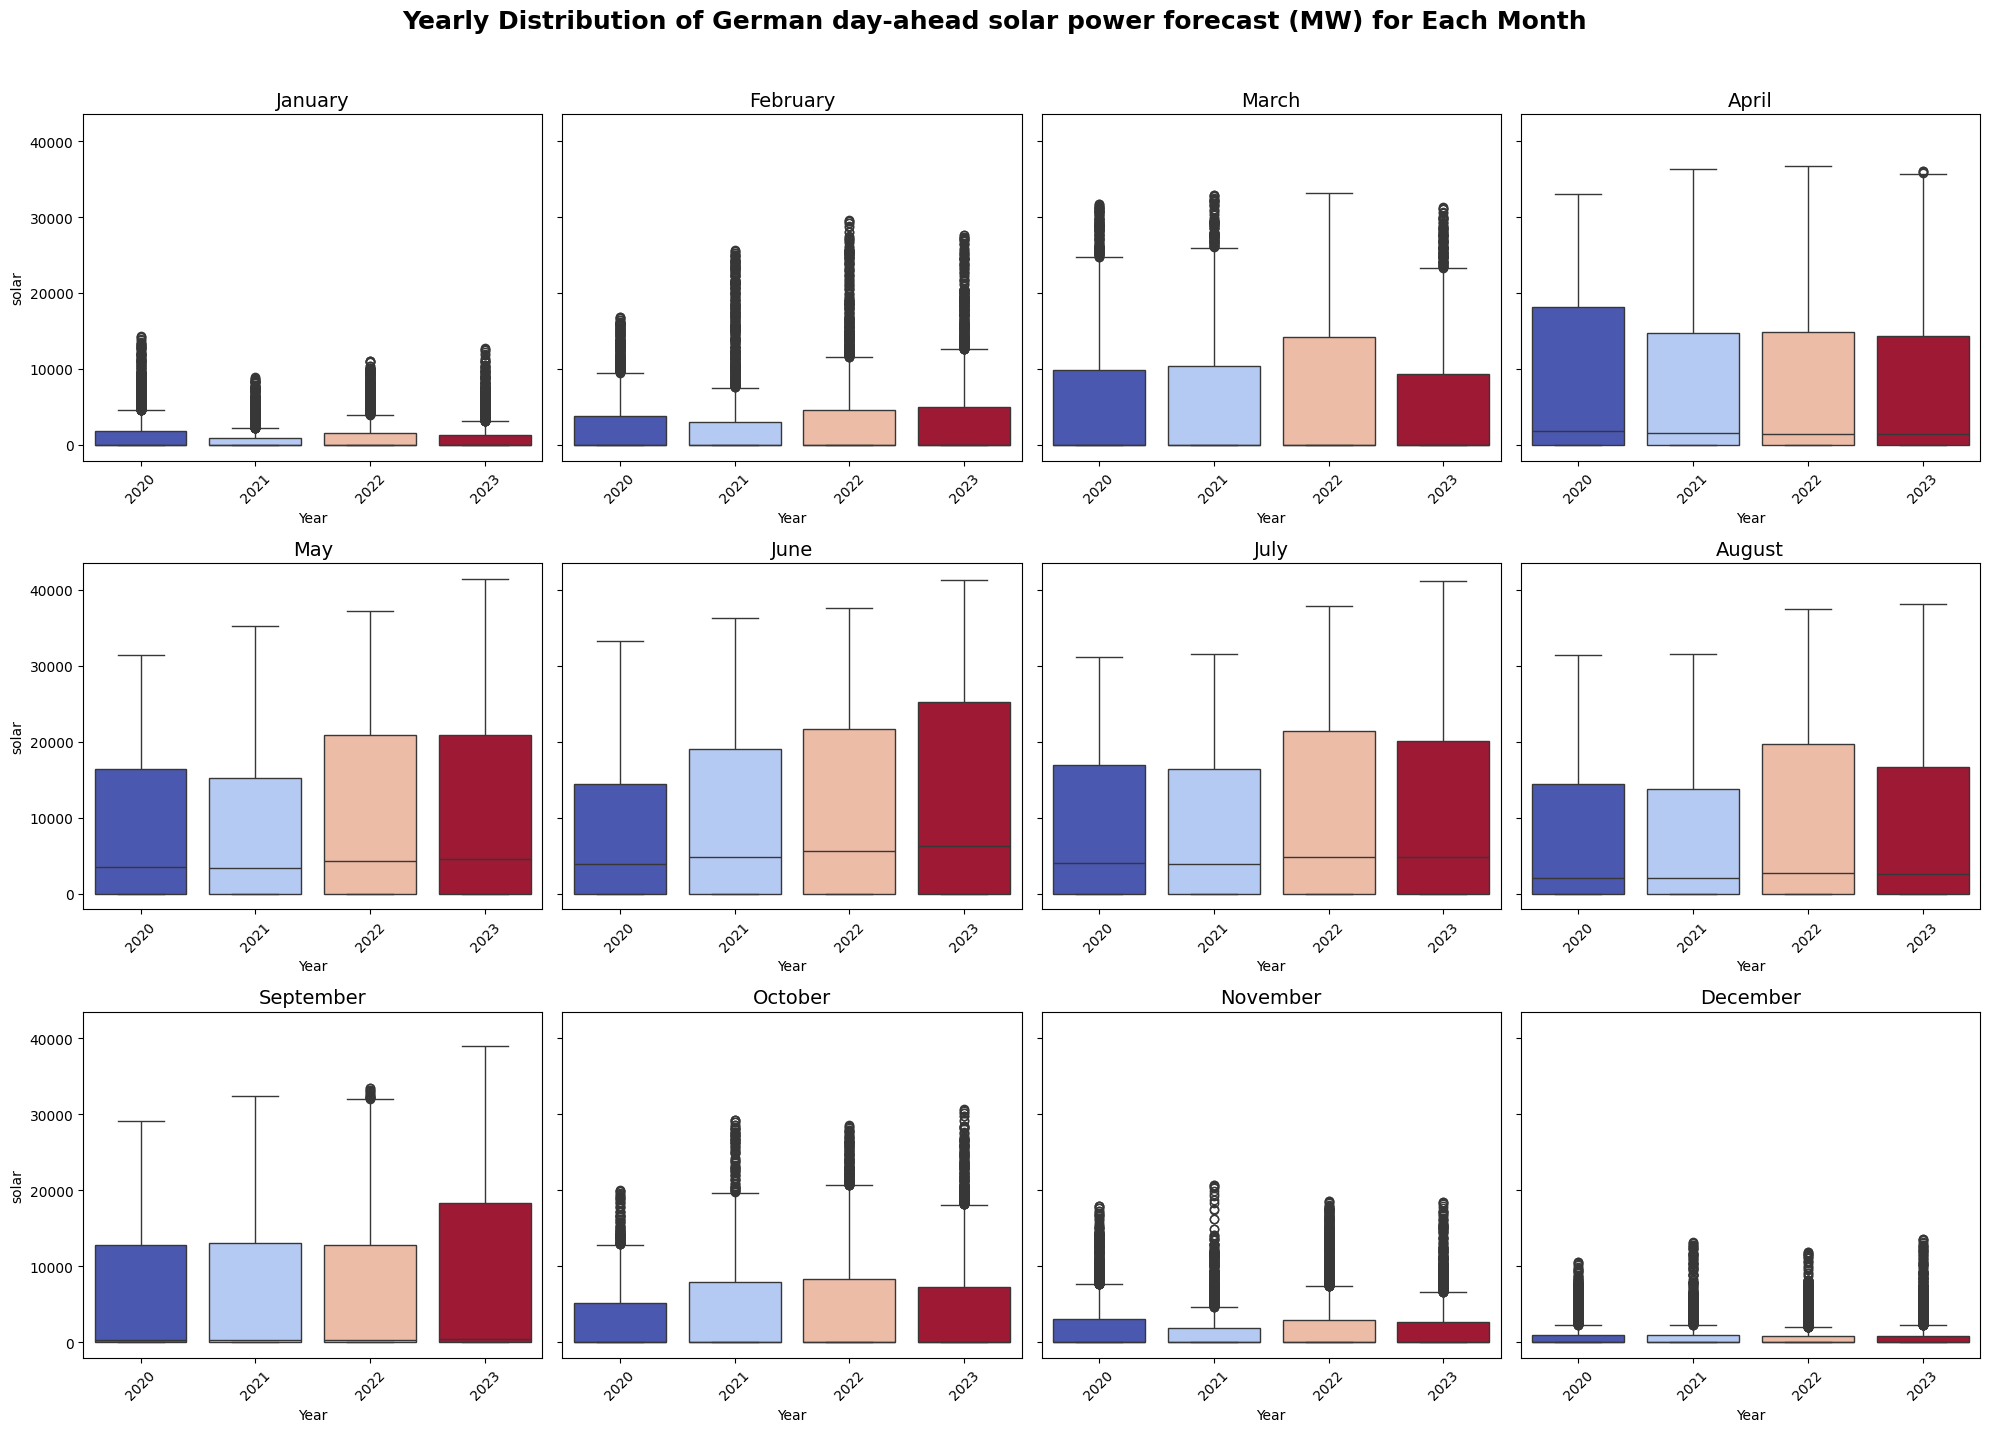

In [15]:
def plot_monthly_yearly_boxplots(df, column):
    """
    Plots a 3x4 grid of yearly boxplots for each month for the specified column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data with a datetime index.
        column (str): The column to visualize with boxplots.
    """
    df['Year'] = df.index.year
    df['Month'] = df.index.month_name()
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 14), sharey=True)
    axes = axes.flatten()

    for idx, month in enumerate(MONTHS):
        month_data = df[df['Month'] == month]
        sns.boxplot(
            x='Year', y=column, data=month_data, ax=axes[idx], palette='coolwarm', 
            hue='Year', legend=False
        )
        axes[idx].set_title(f"{month}", fontsize=14)
        axes[idx].set_xlabel("Year")
        axes[idx].set_ylabel(column)
        axes[idx].tick_params(axis='x', rotation=45)

    for idx in range(len(MONTHS), len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f"Yearly Distribution of {PLOT_CONFIGS[column]["title"]} for Each Month", fontsize=18, y=1.02, fontweight="bold")
    plt.tight_layout()
    plt.show()

plot_monthly_yearly_boxplots(df, 'wind')
plot_monthly_yearly_boxplots(df, 'solar')

The distributions across the years are not identical, and for wind outliers are not consistently identified throughout the years compared to solar where they are constantly identifed during fall and winter. Before thinking about an outlier reduction technique, it’s essential to determine whether these outliers represent data errors or natural events. To investigate further, we analyze the two periods with the most outliers: **August 2020** and **September 2021**.

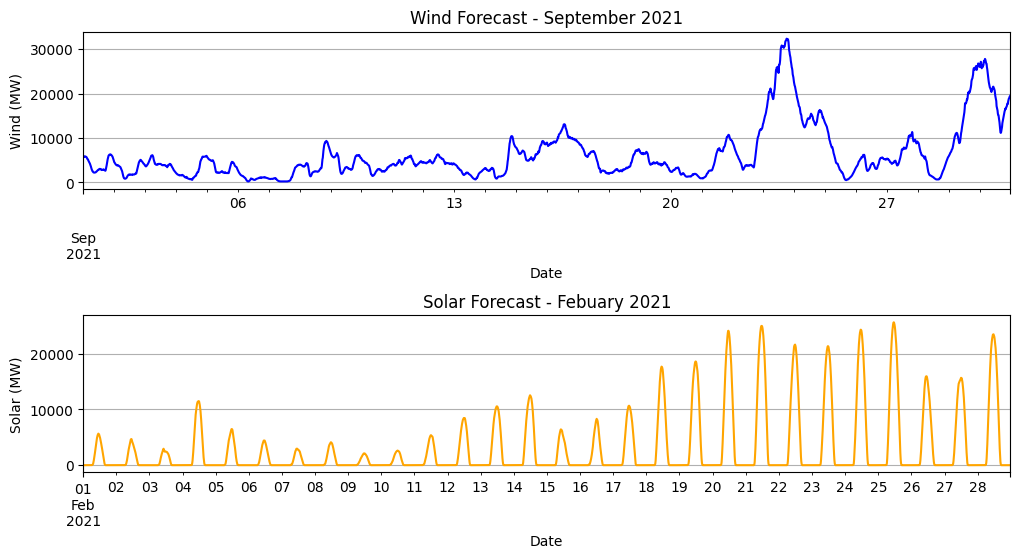

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
plt.tight_layout(h_pad=7)
df.loc["2021-09", "wind"].plot(ax=ax1, color="blue", title="Wind Forecast - September 2021")
ax1.set_ylabel("Wind (MW)")
ax1.grid(True)
df.loc["2021-02", "solar"].plot(ax=ax2, color="orange", title="Solar Forecast - Febuary 2021")
ax2.set_ylabel("Solar (MW)")
ax2.set_xlabel("Date")
ax2.grid(True)

plt.show()

By visualizing the time series, it becomes evident that many of these “outliers” are natural events, such as peaks due to strong winds, rather than data errors. This underscores the importance of understanding the context of outliers before applying reduction techniques such as outlier removal.

### EDA: Conclusion

- Wind: Right Positve right skewed dsitribution where outliers come from natural methorological phonoma. Need to make the distribution more "normal"

- Soalr: Right skewed distribution with a lot of 0 values due to the nightlife, outliers also come from natural phenomena 

- Load: Symetric distrbution wiht a slight bimodality but which ca be ignored as its intensity is very low, no trasnformation & outlier handling required.

- Spread: Several extreme values broaden the range of teh dsitribution which makese it looked peaked around 0, need to address those extreme values so as to extratc a good dsitribution shape.

## **Data Processing**

### **Handling outliers of spread**

#### **Winsorization: Global Outlier Handling**

The spread data exhibits extreme values that can distort the distribution and negatively impact the analysis. Winsorization is an effective technique to handle such outliers by capping the extreme values to a specific percentile. 

This approach ensures that the impact of outliers is mitigated without entirely removing them, preserving the overall structure of the data while reducing skewness and kurtosis. Winsorization is particularly useful when the spread's extreme values are suspected to arise from rare but plausible events rather than errors.

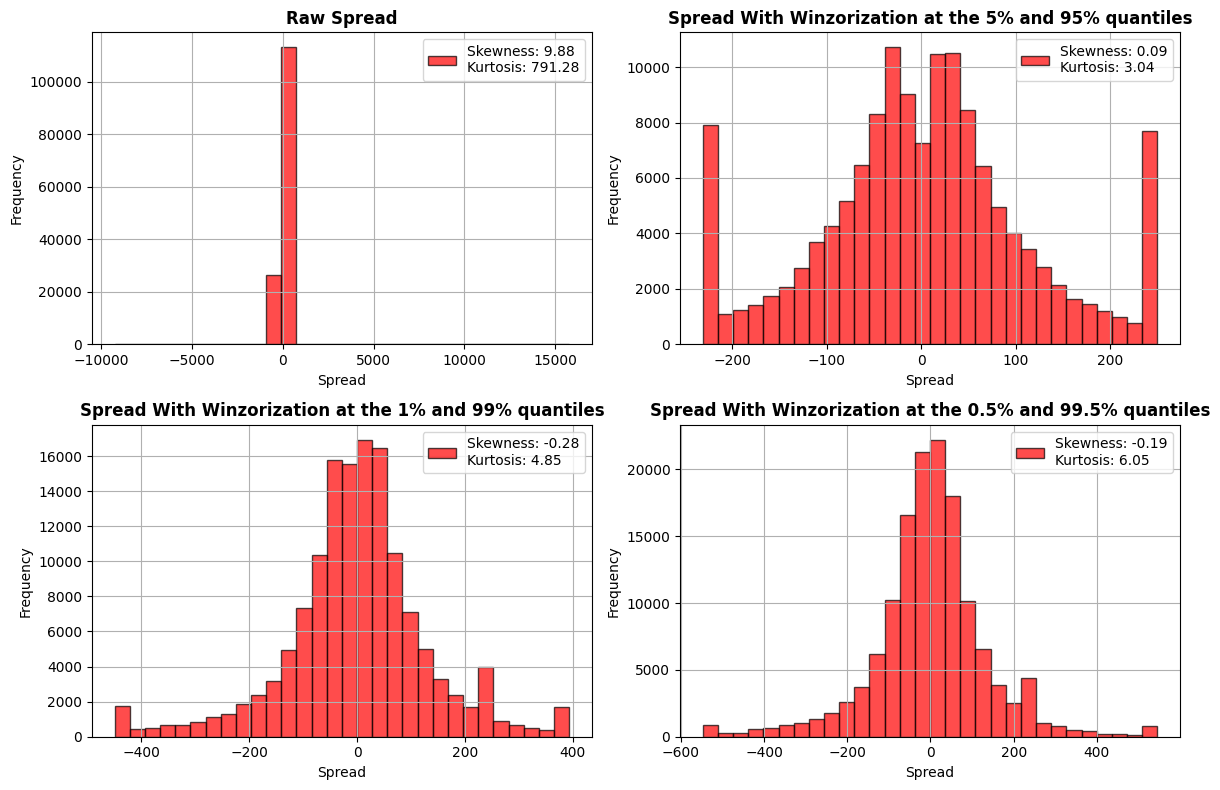

In [17]:
plot_configs_spread = {
    "spread": {
        "title": "Raw Spread",
        "label": "Spread",
        "color": "red",
        
    },
    "spread_winsorized_5_pct": {
        "title": "Spread With Winzorization at the 5% and 95% quantiles",
        "label": "Spread",
        "color": "red"
    },
    "spread_winsorized_1_pct": {
        "title": "Spread With Winzorization at the 1% and 99% quantiles",
        "label": "Spread",
        "color": "red"
    },
    "spread_winsorized_05_pct": {
        "title": "Spread With Winzorization at the 0.5% and 99.5% quantiles",
        "label": "Spread",
        "color": "red"
    }
}

spread_winsorized_5_pct = winsorize(df["spread"].copy(), limits=[0.05, 0.05])
spread_winsorized_1_pct = winsorize(df["spread"].copy(), limits=[0.01, 0.01])
spread_winsorized_05_pct = winsorize(df["spread"].copy(), limits=[0.005, 0.005])
df["spread_winsorized_5_pct"] = spread_winsorized_5_pct
df["spread_winsorized_1_pct"] = spread_winsorized_1_pct
df["spread_winsorized_05_pct"] = spread_winsorized_05_pct

plot_histograms(df[plot_configs_spread.keys()], plot_configs=plot_configs_spread)

- **5%-95% Winsorization**: Achieves the lowest skewness and kurtosis, resulting in a more symmetric appearance. However, the distribution becomes overly compressed with sharp cutoffs around ±200, potentially distorting meaningful extreme events.

- **1%-99% Winsorization**: Balances the reduction of skewness and kurtosis while preserving the distribution's natural shape. The tails are less compressed, allowing for a better representation of moderate outliers.

- **0.5%-99.5% Winsorization**: Retains broader tails while reducing extreme outliers. This approach preserves the natural variability in the data, at the cost of a leptokurtic distribution, which is peaked around 0 with fatter tails than the normal distribution.

**Conclusion:** The **1%-99% Winsorization** is the most appropriate choice as it effectively balances the reduction of skewness and kurtosis while maintaining a reasonable and natural distribution shape. 

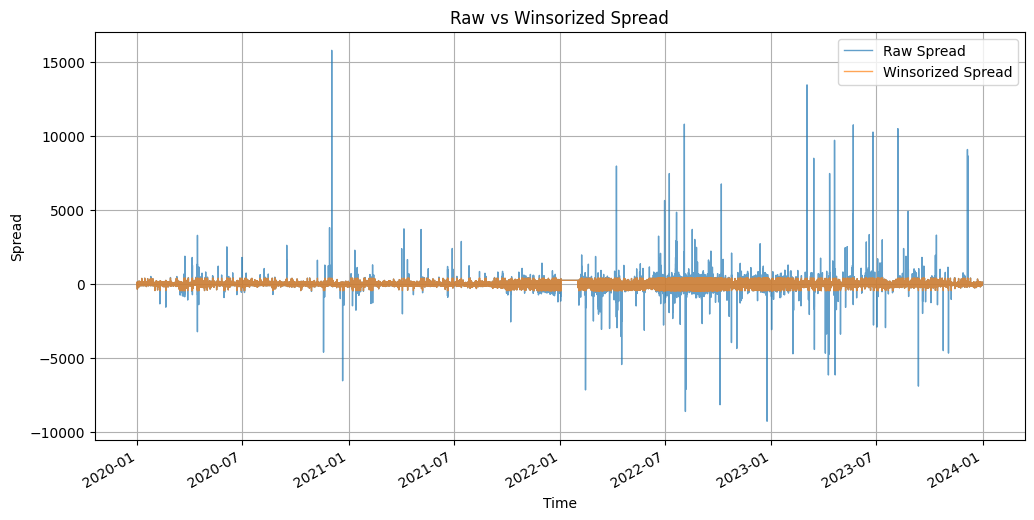

In [18]:
plt.figure(figsize=(12, 6))
df.loc["2020":, "spread"].plot(label="Raw Spread", alpha=0.7, linewidth=1)
df.loc["2020":, "spread_winsorized_1_pct"].plot(label="Winsorized Spread", alpha=0.7, linewidth=1)
plt.title("Raw vs Winsorized Spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

Winsorization effectively reduces outliers, but its global application to the entire distribution overlooks temporal differences. For instance, periods like **August 2022** exhibit significantly higher spread volatility compared to **August 2020**, highlighting the limitations of this approach in capturing regime-dependent variability.

### **Hampel Filter: A Robust Alternative**


The **Hampel Filter** offers a localized approach to outlier detection in time-series data, addressing the limitations of global methods like winsorization. By operating within a **rolling window**, it adapts to temporal variability and different regimes, preserving natural fluctuations while mitigating extreme deviations.

#### Key Features:
1. **Local Adaptation**: Outliers are identified relative to the **local median**, making the method responsive to changing trends and volatility.

2. **Robust Metrics**: Uses the **median absolute deviation (MAD)** for dispersion, resistant to extreme values.

3. **Flexible Thresholds**: Customizable thresholds (e.g., 3 MADs) allow fine-tuning for specific datasets.

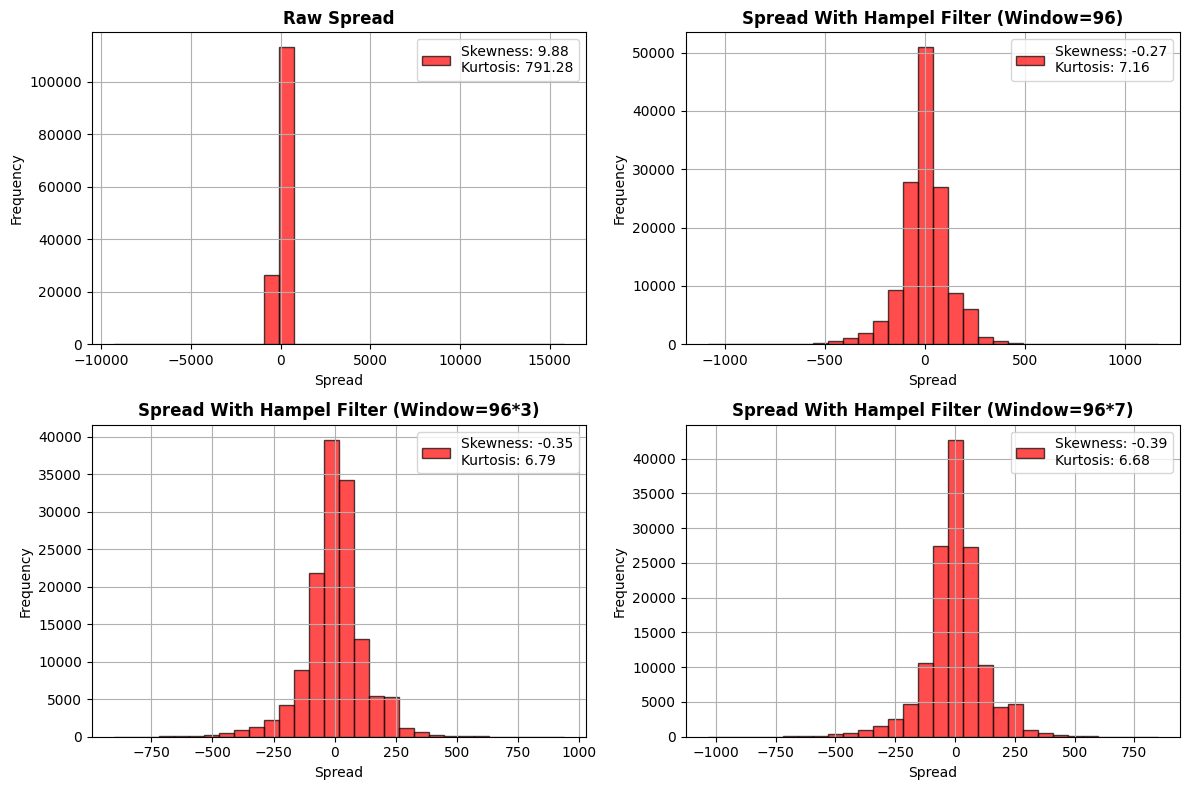

In [19]:
from scipy.stats import median_abs_deviation

def apply_hampel_filter(series, window_size, n_sigmas):
    """
    Applies the Hampel filter to a time-series.

    Args:
        series (pd.Series): The time series to filter.
        window_size (int): Size of the rolling window.
        n_sigmas (float): Threshold for identifying outliers (based on MAD).

    Returns:
        pd.Series: The filtered time series.
    """
    rolling_median = series.rolling(window=window_size, center=True).median()
    mad = series.rolling(window=window_size, center=True).apply(median_abs_deviation)
    threshold = n_sigmas * mad
    outliers = (series - rolling_median).abs() > threshold
    filtered_series = series.copy()
    filtered_series[outliers] = rolling_median[outliers]
    return filtered_series

df["spread_hampel_1d"] = apply_hampel_filter(df["spread"], window_size=96*1, n_sigmas=3)
df["spread_hampel_3d"] = apply_hampel_filter(df["spread"], window_size=96*3, n_sigmas=3)
df["spread_hampel_7d"] = apply_hampel_filter(df["spread"], window_size=96*7, n_sigmas=3)

plot_configs_hampel = {
    "spread": {
        "title": "Raw Spread",
        "label": "Spread",
        "color": "red",
    },
    "spread_hampel_1d": {
        "title": "Spread With Hampel Filter (Window=96)",
        "label": "Spread",
        "color": "red",
    },
    "spread_hampel_3d": {
        "title": "Spread With Hampel Filter (Window=96*3)",
        "label": "Spread",
        "color": "red",
    },
    "spread_hampel_7d": {
        "title": "Spread With Hampel Filter (Window=96*7)",
        "label": "Spread",
        "color": "red",
    },
}

hampel_cols = ["spread_hampel_1d", "spread_hampel_3d", "spread_hampel_7d"]
plot_histograms(df[plot_configs_hampel.keys()], plot_configs=plot_configs_hampel)

- The **1-day window** (96 intervals) reduces outliers but retains more short-term variability, resulting in the highest kurtosis among the filtered versions.

- The **3-day and 7-day windows** yield similar distributions, with reduced skewness and kurtosis, providing a reasonable balance between smoothing and preserving meaningful variability.

For now, we arbitrarily select the **3-day window** as it offers a balance between local variability and smoothing without over-simplifying the data.

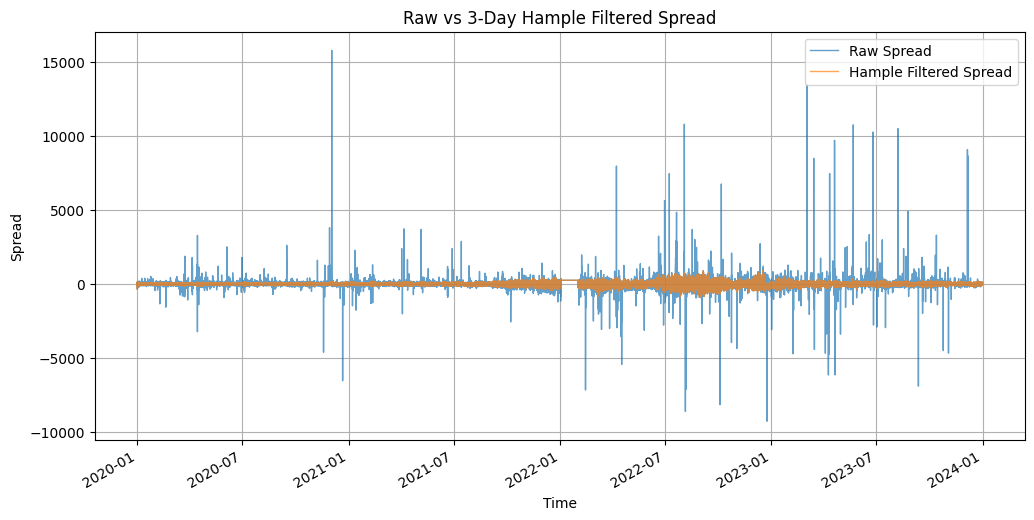

In [20]:
plt.figure(figsize=(12, 6))
df["spread"].plot(label="Raw Spread", alpha=0.7, linewidth=1)
df[hampel_cols[1]].plot(label="Hample Filtered Spread", alpha=0.7, linewidth=1)
plt.title("Raw vs 3-Day Hample Filtered Spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

### **Data Transformation of Wind: Log vs Square root vs Box-Cox**

### **Log Transformation**

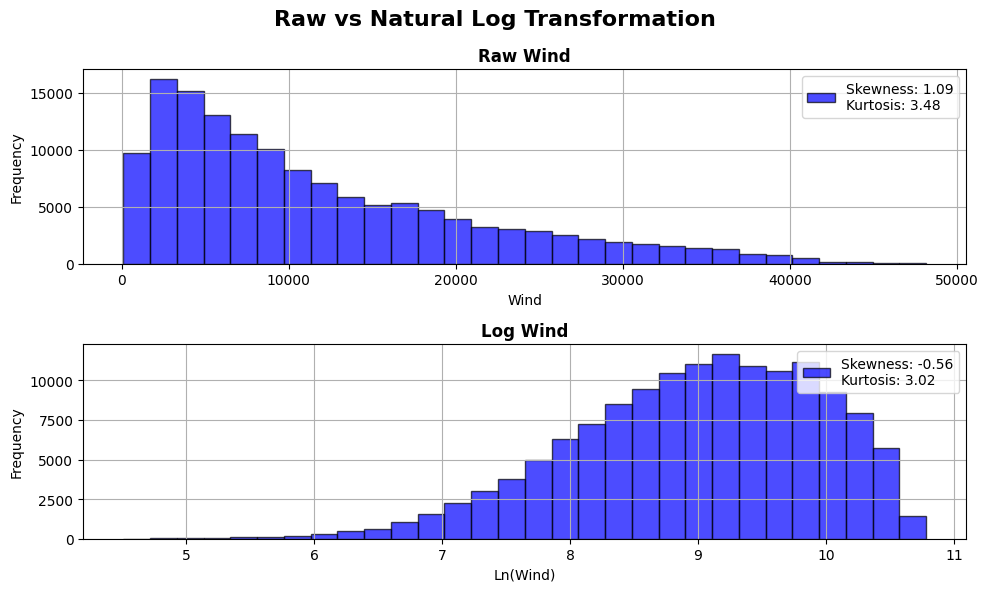

In [21]:
plot_configs_wind = {
    "wind": {
        "title": "Raw Wind",
        "label": "Wind",
        "color": "blue",
    }
}    
plot_configs_wind_log = {
    "wind_log": {
        "title": "Log Wind",
        "label": "Ln(Wind)",
        "color": "blue"
    }
}
plot_configs_wind.update(plot_configs_wind_log)

df["wind_log"] = np.log(df["wind"])
plot_histograms(df[plot_configs_wind.keys()], title="Raw vs Natural Log Transformation", figsize=(10, 6), plot_configs=plot_configs_wind)

The log transformation for wind and load is reasolably good despite observing a slight skewness on the left, howveer for solar it is not performing well, thus we must investigate othe rtrasnfromations whihc could be more appropriate.

### **Square Root Transformation**

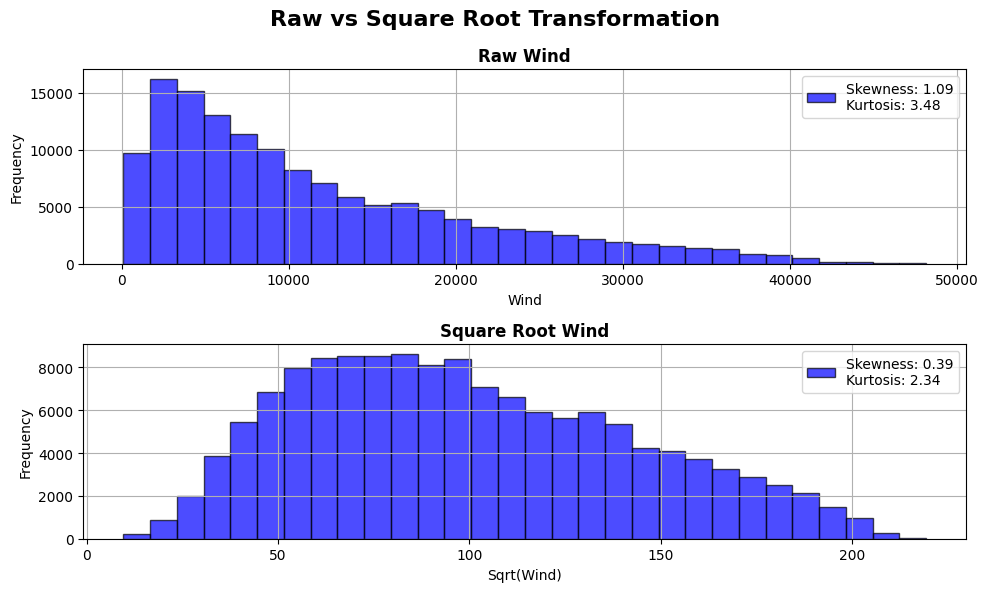

In [22]:
plot_configs_wind_sqrt = {
    "wind_sqrt": {
        "title": "Square Root Wind",
        "label": "Sqrt(Wind)",
        "color": "blue"
    }
}
plot_configs_wind.update(plot_configs_wind_sqrt)

df["wind_sqrt"] = np.sqrt(df["wind"])
plot_histograms(df[["wind", "wind_sqrt"]], title="Raw vs Square Root Transformation", figsize=(10, 6), plot_configs=plot_configs_wind)

Now the distribution is sloightly right skew for wind and left skewed for load, however for solar, the square root reduces the amplitude of the solar power forecatss but it is still not normal.

### **Box-Cox Transformation**

The Box-Cox transformation is a widely used technique for normalizing data to meet the assumptions of statistical models. It applies a power transformation controlled by a parameter, lambda ($\lambda$). The value of $\lambda$ determines the type of transformation applied: 

- When $\lambda = 0$, the transformation is logarithmic.
- For $\lambda \neq 0$, it applies a power transformation that can range from square root to inverse transformations.

This flexibility makes Box-Cox particularly effective for handling skewed data and stabilizing variance. The formula for the transformation is:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\ln(y), & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $y$ is the original data (must be positive).
- $\lambda$ is the transformation parameter.

This transformation ensures that the data becomes closer to a normal distribution, improving the performance of statistical and machine learning models.

Box-Cox Lambdas: {'wind': np.float64(0.23877356336940433)}


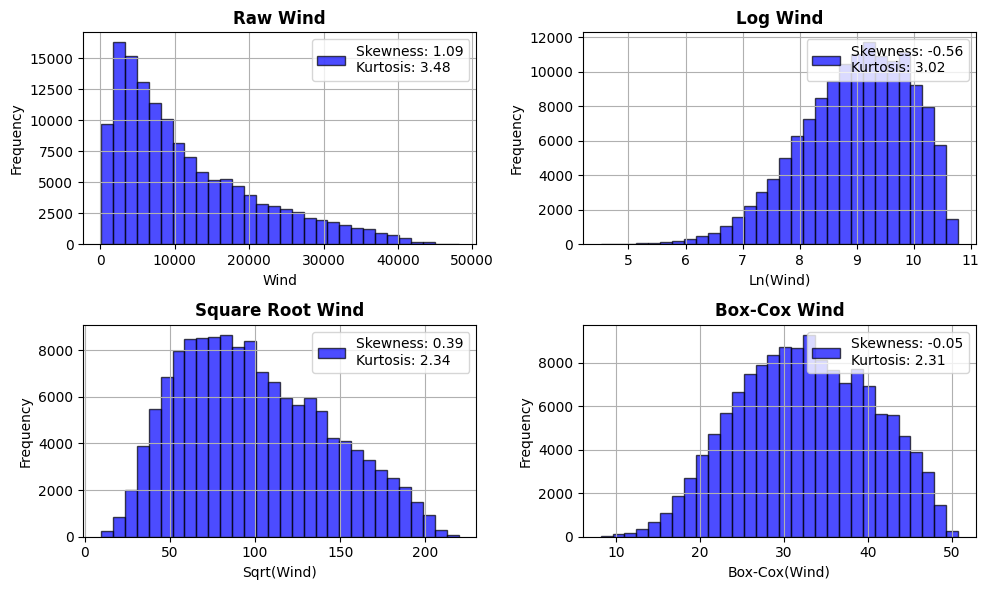

In [23]:
def apply_boxcox(df, columns, espilon=1e-3):
    """
    Apply Box-Cox transformation with correction for 0 values to specified columns in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to apply Box-Cox transformation.
        
    Returns:
        pd.DataFrame: DataFrame with transformed columns and Box-Cox lambdas.
    """
    box_cox_transform = pd.DataFrame(index=df.index, columns=columns)
    boxcox_lambdas = {}

    for col in columns:
        transformed_col = df[col]
        if (df[col] <= 0).any():
            transformed_col += espilon
        box_cox_transform[col], boxcox_lambdas[col] = boxcox(transformed_col)

    return box_cox_transform, boxcox_lambdas

plot_configs_wind_boxcox = {
    "wind_boxcox": {
        "title": "Box-Cox Wind",
        "label": "Box-Cox(Wind)",
        "color": "blue"
    }
}
plot_configs_wind.update(plot_configs_wind_boxcox)

df["wind_boxcox"], boxcox_lambdas = apply_boxcox(df, ["wind"])
print("Box-Cox Lambdas:", boxcox_lambdas)
plot_histograms(df[plot_configs_wind.keys()], figsize=(10, 6), plot_configs=plot_configs_wind)

The Box-Cox transformation combine is the one that transforms the wind distributoion in the more normal way with the lowest skewness and kurtosis.

#### **Filter Remaining Outliers with the Z-score**

Now that the distribution is closer to normal after winsorization, we apply the Z-score to identify and filter any remaining outliers. This step ensures that any residual extreme values, which could still impact the model, are flagged and handled appropriately.

In [24]:
z_scores = zscore(df["wind_boxcox"])
wind_outliers = z_scores.abs() > 3
df.loc[wind_outliers, "wind_boxcox"]

Date
2020-08-08 07:45:00    8.172415
2020-08-08 08:00:00    8.108419
2020-08-08 08:15:00    8.266473
2021-06-26 07:15:00    8.297328
2021-06-26 07:30:00    8.235372
2021-06-26 07:45:00    8.477541
2021-06-26 08:00:00    8.506794
Name: wind_boxcox, dtype: float64

### **Addressing the Prevalence of Zero Observations in Solar Data**

Solar data contains a high number of zero observations, especially during nighttime or overcast conditions. These zeros can heavily influence the distribution and statistical properties of the data, potentially affecting model performance. To address this, appropriate preprocessing steps such as filtering, clipping, or transformation can be applied to better capture meaningful patterns in the data.

### **Yeo-Johnson Transformation**

The Yeo-Johnson transformation extends the Box-Cox method to handle both positive and non-positive data, making it suitable for datasets with zeros or negative values. Like Box-Cox, it applies a power transformation controlled by a parameter, $\lambda$, but can adapt to a broader range of data types.

The formula is:

$$
T(x, \lambda) =
\begin{cases} 
\frac{((x + 1)^\lambda - 1)}{\lambda}, & \text{if } \lambda \neq 0, x \geq 0 \\
\ln(x + 1), & \text{if } \lambda = 0, x \geq 0 \\
\frac{-((|x| + 1)^{2 - \lambda} - 1)}{2 - \lambda}, & \text{if } \lambda \neq 2, x < 0 \\
-\ln(|x| + 1), & \text{if } \lambda = 2, x < 0
\end{cases}
$$

Where:
- $x$ is the data point.
- $\lambda$ is the transformation parameter.

This transformation reduces skewness and stabilizes variance, making data more suitable for modeling.

Box-Cox Lambdas: -0.017358545458226377


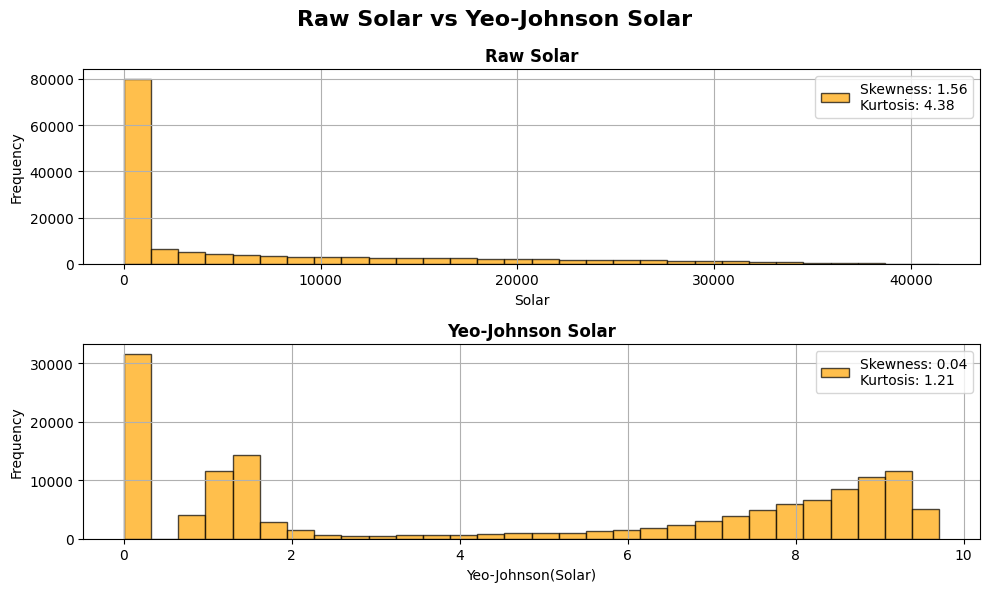

In [25]:
plot_configs_solar = {
    "solar": {
        "title": "Raw Solar",
        "label": "Solar",
        "color": "orange",
    },
    "solar_yeojohnson": {
        "title": "Yeo-Johnson Solar",
        "label": "Yeo-Johnson(Solar)",
        "color": "orange"
    }
}

df["solar_yeojohnson"], boxcox_lambdas = yeojohnson(df["solar"].copy())
print("Box-Cox Lambdas:", boxcox_lambdas)
plot_histograms(df[plot_configs_solar.keys()], title="Raw Solar vs Yeo-Johnson Solar", figsize=(10, 6),plot_configs=plot_configs_solar)

While the transformation significantly reduces skewness (from **1.56** to **0.04**) and kurtosis (from **4.38** to **1.21**), making the distribution closer to normal, it fails to address the large concentration of near-zero values, suggesting that further preprocessing, such as separating daytime and nighttime data, might be necessary.

#### **Daytime vs Nighttime Solar Power Generation**

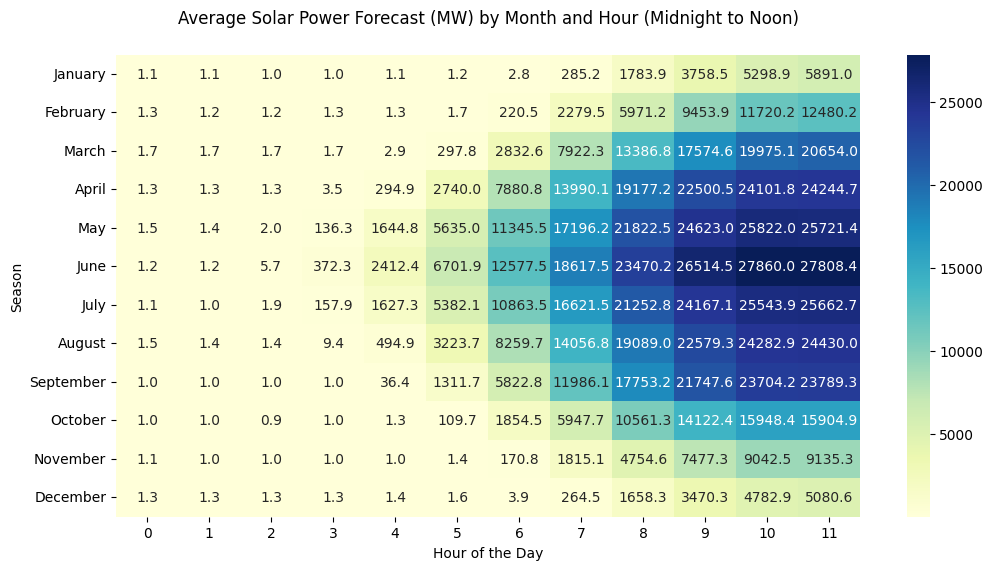

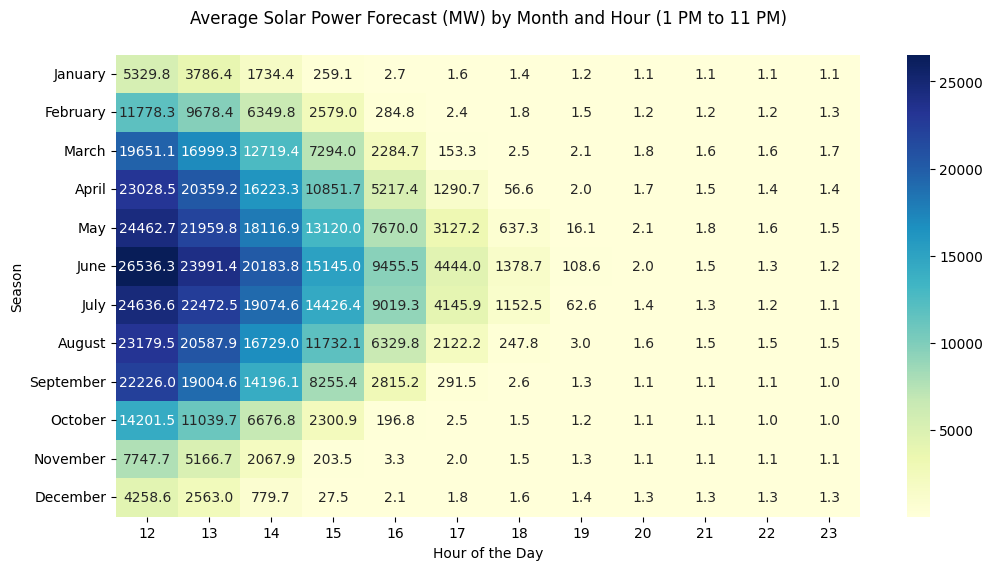

In [26]:
def get_season(date):
    if date.month in [12, 1, 2]:
        return "Winter"
    elif date.month in [3, 4, 5]:
        return "Spring"
    elif date.month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["Season"] = df.index.map(get_season)
df["Month"] = pd.Categorical(df["Month"], categories=MONTHS, ordered=True)
df["Hour"] = df.index.hour

pivot_table = df.pivot_table(
    values="solar", 
    index="Month", 
    columns="Hour", 
    aggfunc="mean",
    observed=False
)

# Split into two parts: midnight to noon and 1 PM to 11 PM
pivot_table_am = pivot_table.loc[:, :11]
pivot_table_pm = pivot_table.loc[:, 12:23]

# Plotting AM hours (Midnight to Noon)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_am, cmap="YlGnBu", annot=True, fmt=".1f", cbar=True)
plt.title("Average Solar Power Forecast (MW) by Month and Hour (Midnight to Noon)", y=1.05)
plt.xlabel("Hour of the Day")
plt.ylabel("Season")
plt.show()

# Plotting PM hours (1 PM to 11 PM)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_pm, cmap="YlGnBu", annot=True, fmt=".1f", cbar=True)
plt.title("Average Solar Power Forecast (MW) by Month and Hour (1 PM to 11 PM)", y=1.05)
plt.xlabel("Hour of the Day")
plt.ylabel("Season")
plt.show()

In [27]:
solar_threshold = 10  # Solar power threshold (MW)
daytime_hours = {}

for month in MONTHS:
    monthly_data = df[df["Month"] == month]
    hourly_avg = monthly_data.groupby(monthly_data.index.hour)["solar"].mean()
    daytime_start = hourly_avg[hourly_avg > solar_threshold].index.min()
    daytime_end = hourly_avg[hourly_avg > solar_threshold].index.max()
    daytime_hours[month] = list(range(daytime_start, daytime_end + 1))
    
daytime_hours

{'January': [7, 8, 9, 10, 11, 12, 13, 14, 15],
 'February': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'March': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'April': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 'May': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'June': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'July': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'August': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 'September': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'October': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'November': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'December': [7, 8, 9, 10, 11, 12, 13, 14, 15]}

A data-driven approach that utilizes the average solar power generation across years for each month and hour serves as a solid foundation for identifying plausible daytime starting and ending hours. However, since the scale is influenced by the entire dataset, complementing this with visual validation ensures that the derived daytime hours are reasonable and account for seasonal and monthly variations effectively

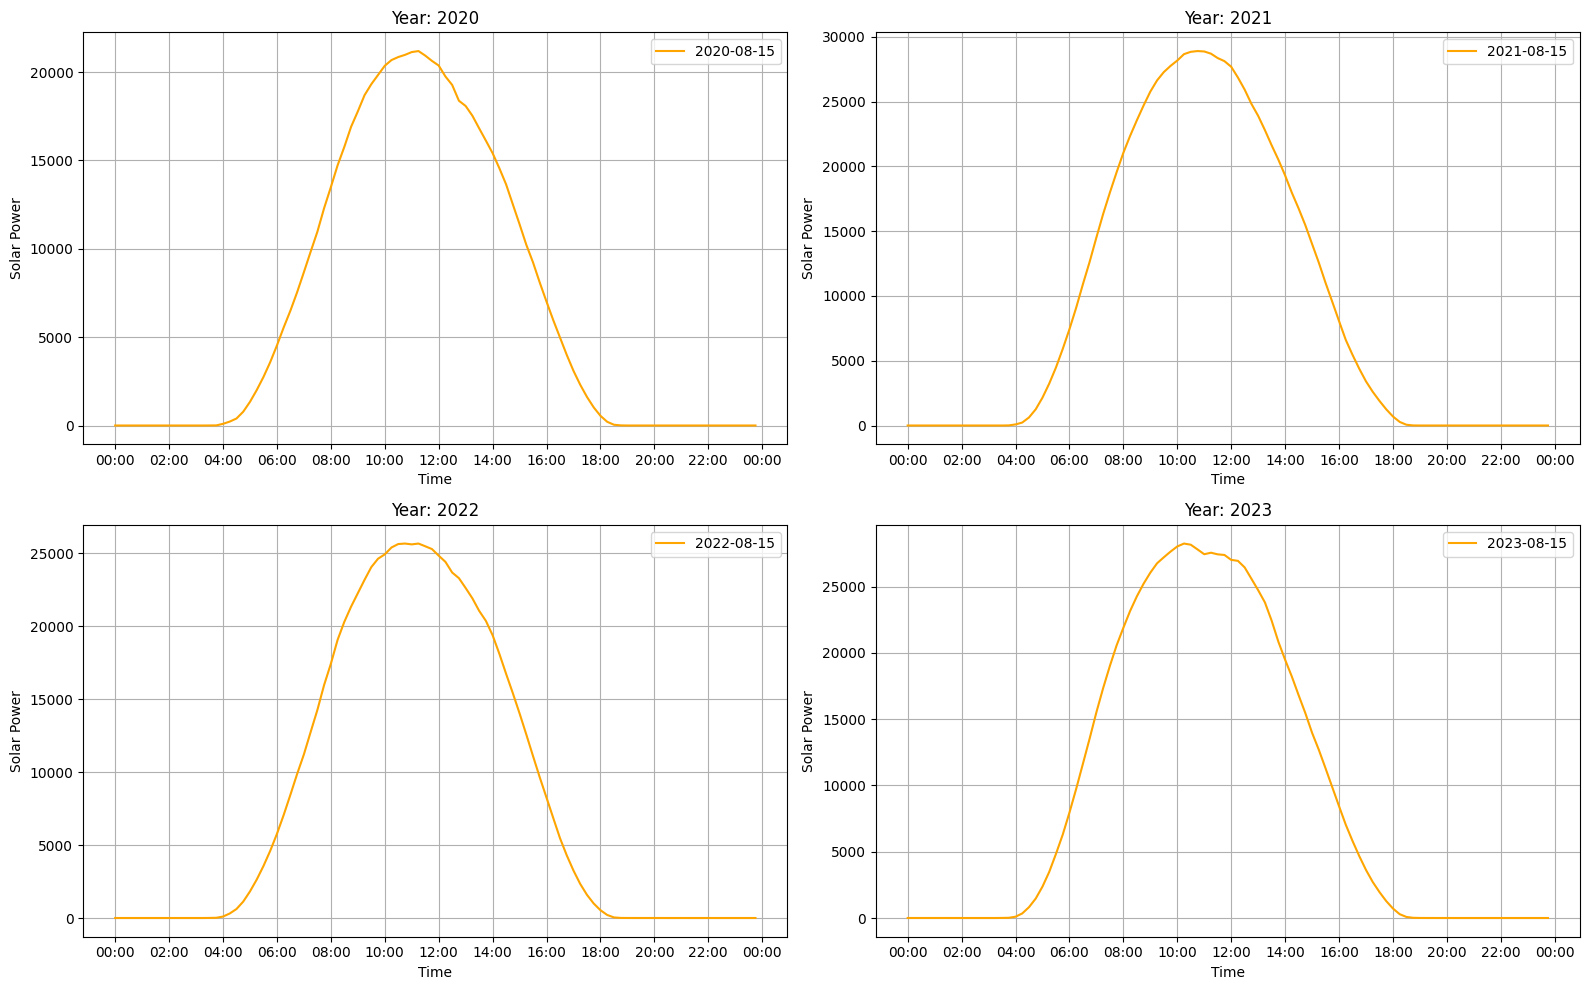

In [28]:
# Specify the day and month to analyze across years
day = 15
month = 8

specific_day_month_data = df[(df.index.day == day) & (df.index.month == month)]
years = df.index.year.unique()

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=False)
axes = axes.flatten()

for idx, year in enumerate(years):
    year_data = specific_day_month_data[specific_day_month_data.index.year == year]
    axes[idx].plot(year_data.index, year_data["solar"], label=f"{year}-{month:02d}-{day}", color="orange")
    axes[idx].set_title(f"Year: {year}")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Solar Power")
    axes[idx].grid(True)
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axes[idx].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[idx].legend()

plt.tight_layout()
plt.show()

Despite the intensity varying across the years, the start and end day times are consistent across the years, by replacing `month` wiht other month values you will see that the conclusion is the same. Now we can define the `daytime` and `nighttime` subsets and plot one particular day on a particular yera across all the months to chekc wether the starting and ending day time sugguested previously are validated graphically.

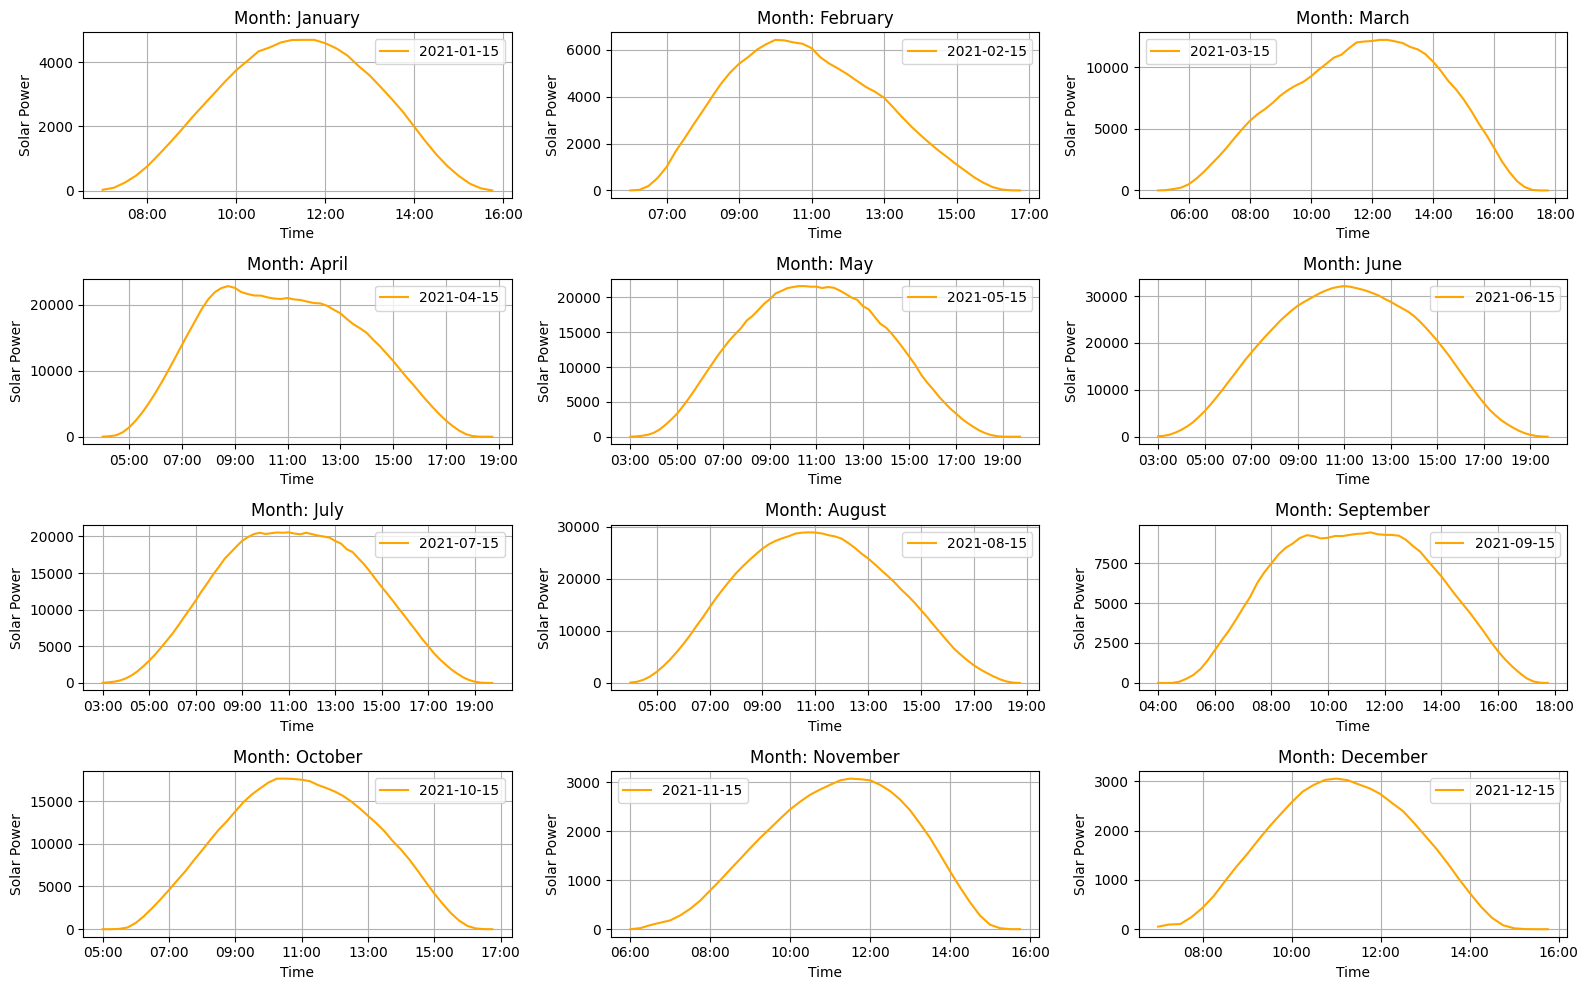

In [29]:
def is_daytime(row):
    month = row['Month']
    hour = row['Hour']
    return hour in daytime_hours[month]

df['Daytime'] = df.apply(is_daytime, axis=1)
daytime = df[df['Daytime']]
nighttime = df[~df['Daytime']]

# Specify the year and the day to analyze
year = 2021
day = 15

specific_year_data = daytime[(daytime.index.year == year) & (daytime.index.day == day)]

months = range(1, 13)
fig, axes = plt.subplots(4,3, figsize=(16, 10), sharey=False)
axes = axes.flatten()

for idx, month in enumerate(months):
    month_data = specific_year_data[specific_year_data.index.month == month]
    axes[idx].plot(month_data.index, month_data["solar"], label=f"{year}-{month:02d}-{day}", color="orange")
    axes[idx].set_title(f"Month: {month_data.index[0].strftime('%B')}")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Solar Power")
    axes[idx].grid(True)
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axes[idx].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=0)
    axes[idx].legend()

plt.tight_layout()
plt.show()

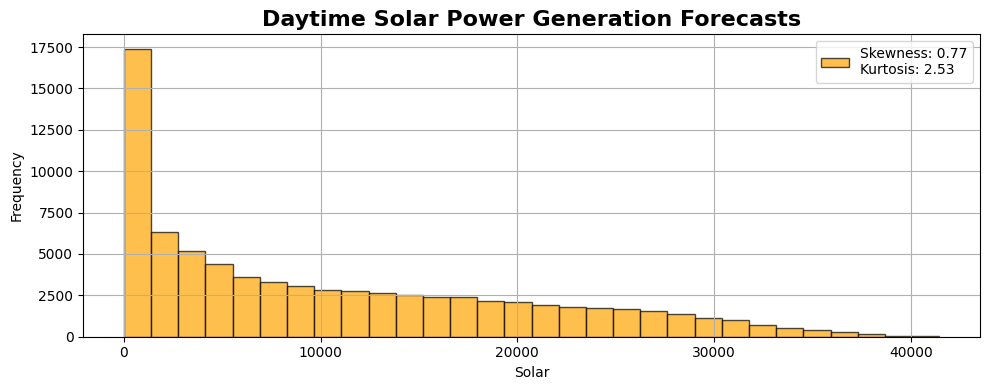

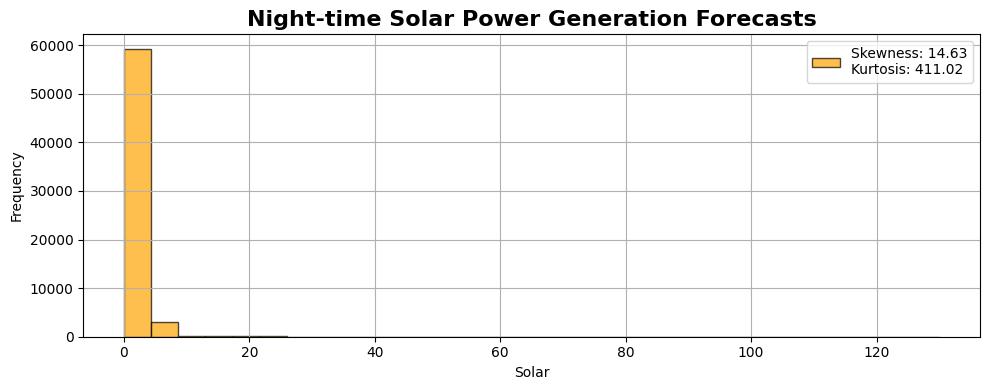

In [30]:
plot_configs_solar_daytime = {
    "solar": {
        "title": "Solar Daytime",
        "label": "Solar",
        "color": "orange"
    }
}
plot_configs_solar_nighttime = plot_configs_solar_daytime.copy()
plot_configs_solar_nighttime["solar"]["title"] = "Solar Nighttime"

plot_histograms(daytime["solar"], title="Daytime Solar Power Generation Forecasts", figsize=(10, 4), plot_configs=plot_configs_solar_daytime)
plot_histograms(nighttime["solar"], title="Night-time Solar Power Generation Forecasts", figsize=(10, 4), plot_configs=plot_configs_solar_nighttime)

Now the distribution as well as skewness and kurtosis coefficients are largely reduced during day-time.

In [31]:
nighttime.sort_values("solar", ascending=False)["solar"].head(10)

Date
2021-08-01 03:45:00    130.0
2023-08-02 03:45:00    129.0
2022-08-02 03:45:00    124.0
2022-08-03 03:45:00    118.0
2020-08-01 03:45:00    106.0
2021-08-02 03:45:00    101.0
2023-08-03 03:45:00     98.0
2021-08-04 03:45:00     95.0
2021-08-03 03:45:00     93.0
2021-08-05 03:45:00     90.0
Name: solar, dtype: float64

The 10 largest noises are observed early during **August 2023** just before the day time strating at **4:00 am**, in that acse we can simply filter them and reduce all of them to 0.

In [32]:
daytime.loc[daytime["solar"] == 0, "solar"]

Date
2020-01-02 15:45:00    0.0
2020-01-03 15:45:00    0.0
2020-01-04 15:45:00    0.0
2020-01-05 15:45:00    0.0
2020-01-08 15:45:00    0.0
                      ... 
2021-12-27 15:45:00    0.0
2021-12-28 15:45:00    0.0
2021-12-29 15:45:00    0.0
2021-12-30 15:45:00    0.0
2021-12-31 15:45:00    0.0
Name: solar, Length: 975, dtype: float64

The same goes during daytime where values reach exactly 0 near the end of daytime, howveer in contrast to night time it seems better to kepe them as they are and instead of using Box-Cox we opt for Yeo-Johnson.

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_40171/3771153662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nighttime.loc[nighttime.index, "solar_cleaned"] = 0.0
/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_40171/3771153662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime.loc[daytime.index, "solar_cleaned"] = daytime_solar_yeojohnson


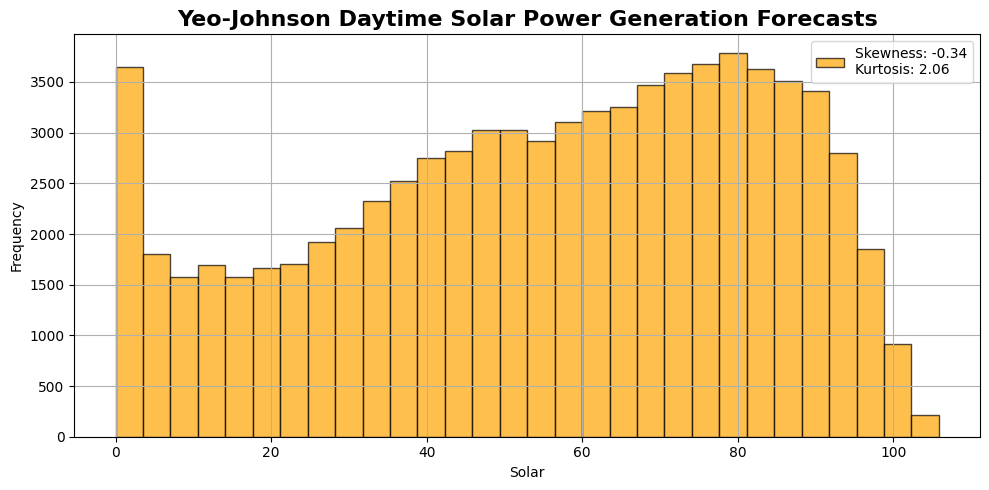

In [33]:
# Filter solar noise during night-time
nighttime.loc[nighttime.index, "solar_cleaned"] = 0.0

daytime_solar_yeojohnson, _ = yeojohnson(daytime["solar"].copy())
daytime.loc[daytime.index, "solar_cleaned"] = daytime_solar_yeojohnson

plot_configs_solar_daytime["solar_cleaned"] = plot_configs_solar_daytime.pop("solar")
plot_histograms(daytime["solar_cleaned"], title="Yeo-Johnson Daytime Solar Power Generation Forecasts", figsize=(10, 5), plot_configs=plot_configs_solar_daytime)

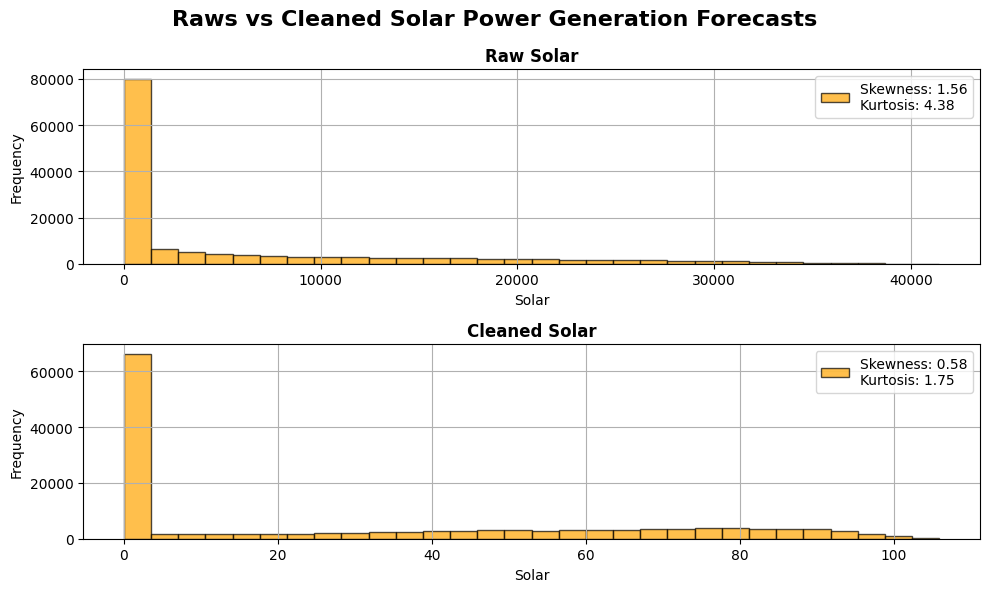

In [34]:
df["solar_cleaned"] = 0.0
df.loc[daytime.index, "solar_cleaned"] = daytime["solar_cleaned"]
df.loc[nighttime.index, "solar_cleaned"] = nighttime["solar_cleaned"]

plot_configs_solar.update(plot_configs_solar_daytime)
plot_configs_solar["solar_cleaned"]["title"] = "Cleaned Solar"
if "solar_yeojohnson" in plot_configs_solar:
    del plot_configs_solar["solar_yeojohnson"]

plot_histograms(df[plot_configs_solar.keys()], title="Raws vs Cleaned Solar Power Generation Forecasts", figsize=(10, 6), plot_configs=plot_configs_solar)

## **Feature Engineering**

In [35]:
regressors = ["wind_boxcox", "solar_cleaned", "Daytime", "load"]
X_train = df[regressors].copy()

#### **Date & Time Features**

These features capture meaningful patterns tied to specific times and dates. For example, energy demand typically rises during the day, is lower on weekends than weekdays, and peaks in winter due to cold weather. Similarly, solar power generation varies seasonally and even over the years, and wind power sharply increases in winter compared to summer.

In [77]:
def extract_time_features(df):
    """
    Extracts various time-based features from a DataFrame with a DatetimeIndex,
    including fractional hours for precise cyclical transformations.
    
    Args:
        df (pd.DataFrame): The DataFrame with a DatetimeIndex.

    Returns:
        pd.DataFrame: The updated DataFrame with new time-based features.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame must have a DatetimeIndex.")

    # Extract basic features
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    df['FractionalHour'] = df['Hour'] + df['Minute'] / 60
    df['Day'] = df.index.day
    df['Weekday'] = df.index.weekday  # 0=Monday, 6=Sunday
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week.astype(int)
    
    # Cyclical transformations using fractional hours
    df['Hour_sin'] = np.sin(2 * np.pi * df['FractionalHour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['FractionalHour'] / 24)
    df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
    df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    
    # Weekend and daytime flags
    df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['IsDaytime'] = df["solar_cleaned"].apply(lambda x: 1 if x > 0 else 0)    
    
    # Add a holiday flag for Germany
    german_holidays = holidays.Germany()
    df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in german_holidays else 0)
    
    return df

df = extract_time_features(df)

<Axes: xlabel='Hour_sin', ylabel='Hour_cos'>

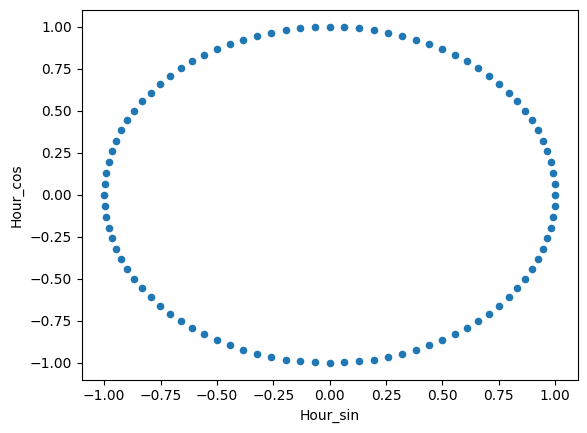

In [95]:
df.loc["2020-12-25", ["Hour_sin", "Hour_cos"]].plot(x="Hour_sin", y="Hour_cos", kind="scatter")

<Axes: xlabel='Date'>

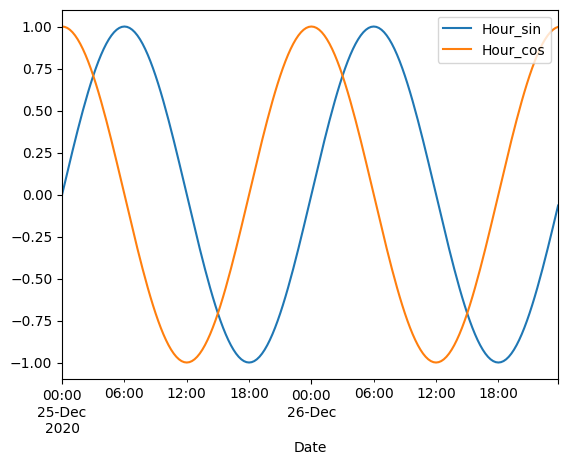

In [97]:
df.loc["2020-12-25":"2020-12-26", ["Hour_sin", "Hour_cos"]].plot()

#### **Cyclical Features**

Simple time-based features may not fully capture periodic patterns such as daily, weekly, and annual cycles. Cyclical transformations using **trigonometric functions** or **Fourier transforms** address this limitation, enabling models to learn seasonality more effectively.

In [ ]:
def extract_fourier_features(df, column, freq=96, n_terms=1):
    t = np.arange(len(df))
    for i in range(1, n_terms + 1):
        df[f'{column}_sin_{i}'] = np.sin(2 * np.pi * i * t / freq)
        df[f'{column}_cos_{i}'] = np.cos(2 * np.pi * i * t / freq)
    return df

def extract_stl_features(df, column, period=96):
    stl = STL(df[column], period=period)
    result = stl.fit()
    df[f'{column}_trend'] = result.trend
    df[f'{column}_seasonal'] = result.seasonal
    df[f'{column}_residual'] = result.resid
    return df

def extract_mstl_features(df, column, periods, robust=False):
    """
    Adds MSTL decomposition features (trend, seasonal components, and residual) to the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the time series data.
        column (str): Column to decompose using MSTL.
        periods (list): List of seasonal periods (e.g., [96, 672] for daily and weekly in 15-min data).
        robust (bool): Whether to use robust loess for the decomposition.
        
    Returns:
        pd.DataFrame: Updated DataFrame with MSTL features.
    """
    mstl = MSTL(df[column], periods=periods, robust=robust)
    result = mstl.fit()
    
    # Add trend and residual components
    df[f'{column}_mstl_trend'] = result.trend
    df[f'{column}_mstl_residual'] = result.resid

    # Add each seasonal component
    for idx, period in enumerate(periods):
        df[f'{column}_mstl_seasonal_{period}'] = result.seasonal_components[:, idx]

    return df

#### **Interaction Effects**

Interaction effects capture the combined influence of two or more features on the target variable, which may not be evident when considering individual features alone. For example, the relationship between wind power and the spread might vary depending on the level of solar generation or electricity load.

In [ ]:
def extract_interaction_features(df, interactions, methods=None):
    """
    Extracts specified interaction features from a DataFrame using different techniques.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interactions (list of tuple): List of feature pairs to compute interaction terms.
                                      Each tuple specifies two column names to interact.
        methods (list of str): List of interaction methods to apply. Options:
                               'product', 'sum', 'difference', 'division'. If None, defaults to 'product'.
    
    Returns:
        pd.DataFrame: The updated DataFrame with new interaction features.
    """
    if not isinstance(interactions, list) or not all(isinstance(pair, tuple) for pair in interactions):
        raise ValueError("Interactions must be a list of tuples (e.g., [('Feature1', 'Feature2')]).")
    
    if methods is None:
        methods = ['product']  # Default to product interaction
    
    valid_methods = {'product', 'sum', 'difference', 'division'}
    if not all(method in valid_methods for method in methods):
        raise ValueError(f"Invalid methods provided. Valid methods are: {valid_methods}")
    
    for feature1, feature2 in interactions:
        if feature1 in df.columns and feature2 in df.columns:
            for method in methods:
                if method == 'product':
                    interaction_name = f"{feature1} * {feature2}"
                    df[interaction_name] = df[feature1] * df[feature2]
                elif method == 'sum':
                    interaction_name = f"{feature1} + {feature2}"
                    df[interaction_name] = df[feature1] + df[feature2]
                elif method == 'difference':
                    interaction_name = f"{feature1} - {feature2}"
                    df[interaction_name] = df[feature1] - df[feature2]
                elif method == 'division':
                    interaction_name = f"{feature1} / {feature2}"
                    df[interaction_name] = df[feature1] / (df[feature2] + 1e-6)  # Avoid division by zero
        else:
            raise ValueError(f"Features {feature1} and/or {feature2} not found in DataFrame.")
    
    return df

In [66]:
df

,wind,solar,load,spread,Month,Year,spread_winsorized_5_pct,spread_winsorized_1_pct,spread_winsorized_05_pct,spread_hampel_1d,spread_hampel_3d,spread_hampel_7d,wind_log,wind_sqrt,wind_boxcox,solar_yeojohnson,Season,Hour,Daytime,solar_cleaned
Date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,6084.0,0.0,43915.0,38.40,January,2020,38.40,38.40,38.40,38.40,38.40,38.40,8.713418,78.000000,29.353093,0.000000,Winter,0,False,0.0
2020-01-01 00:15:00,5739.0,0.0,43770.0,-105.93,January,2020,-105.93,-105.93,-105.93,-105.93,-105.93,-105.93,8.655040,75.756188,28.888807,0.000000,Winter,0,False,0.0
2020-01-01 00:30:00,5774.0,0.0,43267.0,-1.48,January,2020,-1.48,-1.48,-1.48,-1.48,-1.48,-1.48,8.661120,75.986841,28.936862,0.000000,Winter,0,False,0.0
2020-01-01 00:45:00,5804.0,0.0,42934.0,3.97,January,2020,3.97,3.97,3.97,3.97,3.97,3.97,8.666303,76.183988,28.977876,0.000000,Winter,0,False,0.0
2020-01-01 01:00:00,5791.0,0.0,42718.0,100.09,January,2020,100.09,100.09,100.09,100.09,100.09,100.09,8.664060,76.098620,28.960123,0.000000,Winter,1,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00,29922.0,2.0,41550.0,102.06,December,2023,102.06,102.06,102.06,102.06,102.06,102.06,10.306349,172.979768,44.875823,1.088203,Winter,22,False,0.0
2023-12-31 23:00:00,29546.0,3.0,40733.0,35.24,December,2023,35.24,35.24,35.24,35.24,35.24,35.24,10.293704,171.889499,44.727901,1.369747,Winter,23,False,0.0
2023-12-31 23:15:00,29204.0,3.0,39805.0,78.57,December,2023,78.57,78.57,78.57,78.57,78.57,78.57,10.282061,170.891779,44.592105,1.369747,Winter,23,False,0.0


## **Feature Engineering**

<Axes: xlabel='Date'>

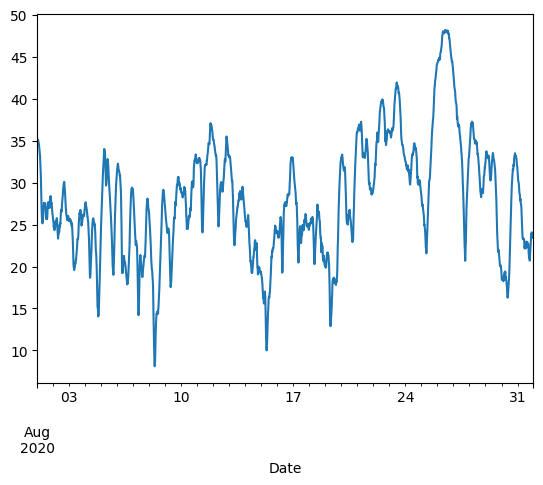

In [62]:
df.loc["2020-08", "wind_boxcox"].plot()

<Axes: xlabel='Date'>

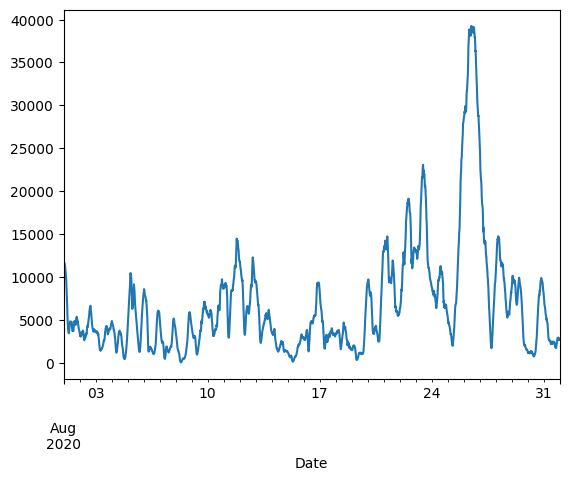

In [63]:
df.loc["2020-08", "wind"].plot()